# CTD corrections applied to delayed-mode data

This notebook performs analysis and correction of GPCTD data from the following C-PROOF glider deployment:

In [1]:
glider_name = 'dfo-bb046'
deploy_name = f'{glider_name}-20220707'
deploy_prefix = f'./glider/{glider_name}/{deploy_name}/'
filepath = 'e:/Glider/data/' # having this is important later for functions that auto-load data
openfile = f'{filepath}/{deploy_name}_delayed.nc'
opengridfile = f'{filepath}/{deploy_name}_grid_delayed.nc'
deployfile = f'{filepath}/{glider_name}/{deploy_name}/deployment.yml'

description = 'Calvert Island Line'
initials = 'AH'

# CTD specs:
sensor = 'CTD_0329'

# For conductivity filter:
accuracy = 0.0003 #accuracy of the sensor is 0.0003 S/m, used as a cutoff on the exclusion criterion

from datetime import date
processing_date = date.today().strftime('%Y%m%d')
processing_protocol = 'C-PROOF_SBE_CTDProcessingReport_v0.2.pdf'
processing_report = 'TBD' # 'CTD_dfo-bb046-20220707_v3'

# Import module for loading .md files
from IPython.display import Markdown, display
import os
os.chdir("C:/Users/hilborna/Documents/Glider_Data/glider_correction/")

In [2]:
# Summarize info for report:
print(f'** {description}:  glider {glider_name}**')
print(f'************')
print(f'* Deployment: {deploy_name}')
print(f'* Sensor: {sensor}')
print(f'')

# print(f'* Protocols are detailed in: {processing_protocol}')
print(f'* Processing steps will be saved in: CTD_{deploy_name}.html')
# print(f'* Files will be located in: {deploy_prefix}')
print(f'* Processed by {initials}, IOS Data Products team, Ocean Sciences Division, Fisheries and Oceans Canada')
print(f'* Processing date: {processing_date}')

** Calvert Island Line:  glider dfo-bb046**
************
* Deployment: dfo-bb046-20220707
* Sensor: CTD_0329

* Processing steps will be saved in: CTD_dfo-bb046-20220707.html
* Processed by AH, IOS Data Products team, Ocean Sciences Division, Fisheries and Oceans Canada
* Processing date: 20241210


In [3]:
display(Markdown("./docs/CTD_1_Preamble.md"))

# 1.0 Preamble
This document describes conductivity, temperature, and pressure data processing steps applied to delayed mode data collected using Sea-Bird Scientific Glider Payload Conductivity Temperature Depth (GPCTD) sensors mounted on C-PROOF Slocum and SeaExplorer autonomous ocean gliders. This sensor has a nominal sampling rate of 1 Hz and was designed specifically for Slocum gliders. This document covers the application of the sensor alignment correction and the thermal lag correction, as well as removal of questionable conductivity values and salinity profiles.

## 1.1 Set up the processing

The processing steps below are applied to delayed mode data stored in a single netcdf timeseries file created using the Pyglider data processing package (https://github.com/c-proof/pyglider). 

The metadata and sensor calibration sheets are available via the deployment page on the C-PROOF website at: **https://cproof.uvic.ca/gliderdata/deployments/dfo-bb046/dfo-bb046-20220707/**


In [4]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import numpy as np
import pathlib
import pyglidersensor as pgs
from pyglider.ncprocess import make_gridfiles

from datetime import datetime, date

import scipy.stats as stats
import scipy.optimize as optimize

import seawater
import gsw

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import cmocean

import pandas as pd

%load_ext autoreload
%autoreload 2

from scipy import signal
import seawater as sw

## 1.2 Profile Check

Check that upcasts and downcasts are being properly identified.
**Negative values should be associated with upcasts**.

Loading: e:/Glider/data//dfo-bb046-20220707_delayed.nc
************
* There are 1759051 data points in total, with 893.0 profiles
* Time period: 2022-07-07 to 2022-07-28
* Depth range: 0 - 1002 metres
************
Identifying upcasts and downcasts. The left panel shows pressure vs. time and the right panel shows profile direction vs. time for a small subset of the time series:


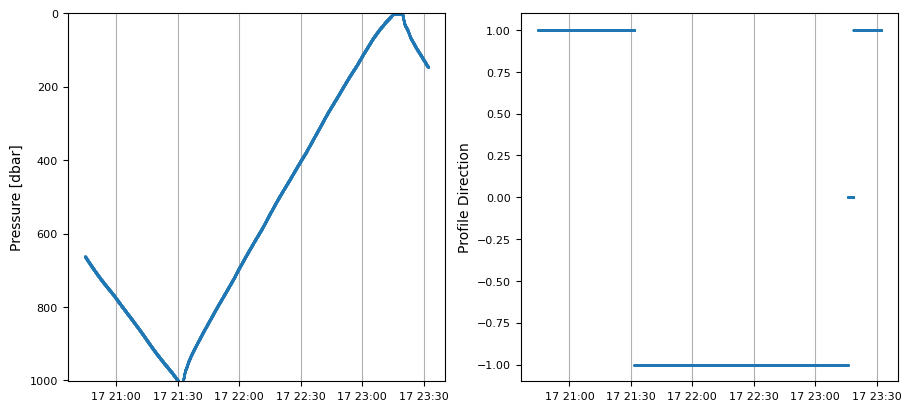

In [5]:
print(f'Loading: {openfile}')

caption = ('Identifying upcasts and downcasts. The left panel shows '
           'pressure vs. time and the right panel shows profile direction vs. '
           'time for a small subset of the time series:')


fname = openfile

with xr.open_dataset(fname) as ds0:
    # SAVE SOME PARAMS FOR PLOTTING DOWN BELOW!
    N = len(ds0.time)
    MAX_DEPTH = np.nanmax(ds0.depth)
    NUM_PROFILES = np.nanmax(ds0.profile_index)
    
    print('************')
    print(f'* There are {N} data points in total, with {NUM_PROFILES} profiles')
    print(f'* Time period: {pd.to_datetime(np.nanmin(ds0.time)).strftime("%Y-%m-%d")} to {pd.to_datetime(np.nanmax(ds0.time)).strftime("%Y-%m-%d")}')
    print(f'* Depth range: {round(np.nanmin(ds0.depth))} - {round(MAX_DEPTH)} metres')
    print('************')
    if N > 50000:
        todo = slice(int(N/2)-5000, int(N/2)+5000)
    else:
        todo = slice(int(N/3), int(2*N/3))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, 
                            constrained_layout=True, 
                            figsize=(9, 4))

    ds = ds0.isel(time=todo)
    axs[0].plot(ds.time, ds.pressure, '.', markersize=1)
    axs[0].set_ylim([MAX_DEPTH, 0])
    axs[0].set_ylabel('Pressure [dbar]')
    axs[0].tick_params(axis='both', labelsize=8)
    axs[0].grid(axis='x')

    axs[1].plot(ds.time, ds.profile_direction, '.', markersize=1)
    axs[1].set_ylabel('Profile Direction')
    axs[1].tick_params(axis='both', labelsize=8)
    axs[1].grid(axis='x') 
    print(caption)

## 1.3 Delayed-mode data prior to corrections

Checking fields (temperature, salinity, conductivity and density) in the delayed-mode data, before any CTD corrections:

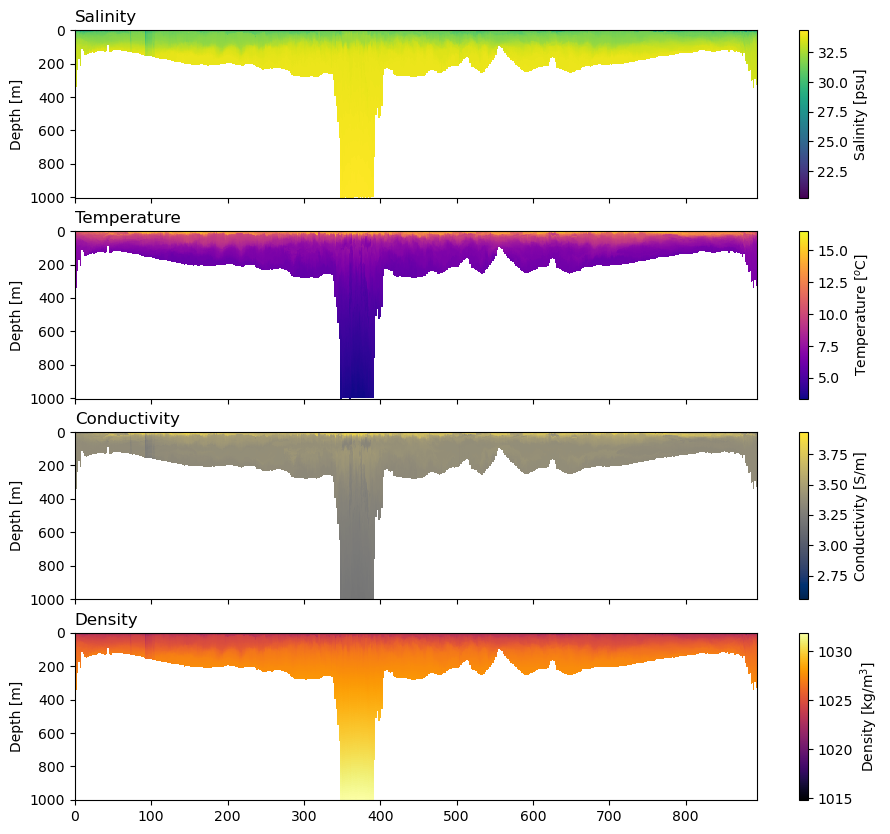

In [6]:
tds = opengridfile
ds = xr.open_dataset(tds)
list(ds.keys())

fig, axs = plt.subplots(4, 1, figsize=(11, 10), sharey=True, sharex=True)

xlims = [0, NUM_PROFILES]
ylims=[MAX_DEPTH,0]
# ylims=[50,0]

pc = axs[0 ].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True)
axs[0].set_ylim(ylims)
axs[1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = 'Salinity [psu]')
axs[0].set_title('Salinity',loc='left')

pc = axs[1].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,cmap='plasma')

fig.colorbar(pc, ax=axs[1], label = 'Temperature [$^o$C]')
axs[1].set_title('Temperature',loc='left')
pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivity'],rasterized=True,cmap='cividis')
fig.colorbar(pc, ax=axs[2], label = 'Conductivity [S/m]')
axs[2].set_title('Conductivity',loc='left')

# pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['oxygen_concentration'],rasterized=True,cmap='inferno')
# fig.colorbar(pc, ax=axs[3])
# axs[3].set_title('Oxygen Concentration',loc='left')

pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['density'],rasterized=True,cmap='inferno')
fig.colorbar(pc, ax=axs[3], label = 'Density [kg/m$^3$]')
axs[3].set_title('Density',loc='left')

axs[0].set_ylabel('Depth [m]');
axs[1].set_ylabel('Depth [m]');
axs[2].set_ylabel('Depth [m]');
axs[3].set_ylabel('Depth [m]');

In [7]:
display(Markdown("./docs/CTD_2_Steps.md"))

# 2.0 Corrections applied to delayed mode data for this mission

**Processing steps:**

1. Identification of anomalous conductivity values
2. Identification of questionable salinity profiles 
3. Sensor alignment correction
4. Thermal lag correction

## 2.1 Identification and removal of anomalous conductivity values

We identify and remove any conductivity values that are obviously unphysical, which is typically caused by air bubbles in the conductivity cell. We use a simple criterion applied to the raw conductivity data. The criterion temporarily flags any data points that are more than **5 standard deviations** away from the overall time series mean for a given depth bin and profile bin, then recomputes the mean and standard deviation, excluding the temporarily flagged values. Conductivity values that still differ from the mean by more than **3 standard deviations** are flagged as 'bad' and set to NaN in the time series. If the difference between the 'bad' values and the mean is less than the accuracy of the sensor, which is 0.0003 S/m for the GPCTD, then those points are not excluded.

This criterion is applied to data binned first by profile index, in increments of **50 profiles**, then binned by depth, in increments of **5 m**. The use of profile index bins rather than time or temperature bins is designed to allow for the removal of unphysical values in both **Hakai Pass** and crossing the continental shelf in **Queen Charlotte Sound**, two mission segments where the distributions of conductivity differ significantly. 

Adjustments to this correction are based on examining the data and making a judgment call about which conductivity values are undeniably 'bad'. In this case, we want to exclude the **extremely low values occurring at the surface** consistent with air bubbles in the cell. Some unphysical values are missed by this correction, and may be caught during the removal of unphysical salinity profiles in further stepsbelow. 

**Note that for this mission:**


In [8]:
srate = stats.mode((np.diff(ds0.time)).astype('timedelta64[s]')).mode
fs = 1/srate.astype(float) #the sampling frequency = 1/(delta t)
print('************')
print(f'The mode of the sampling rate for the GPCTD is one sample every {srate}.')
print('************')

************
The mode of the sampling rate for the GPCTD is one sample every 1 seconds.
************


Temperature vs. conductivity (left), depth vs. conductivity (middle), and conductivity vs. profile index (right), with the red dots showing the unphysical values flagged as bad and removed:


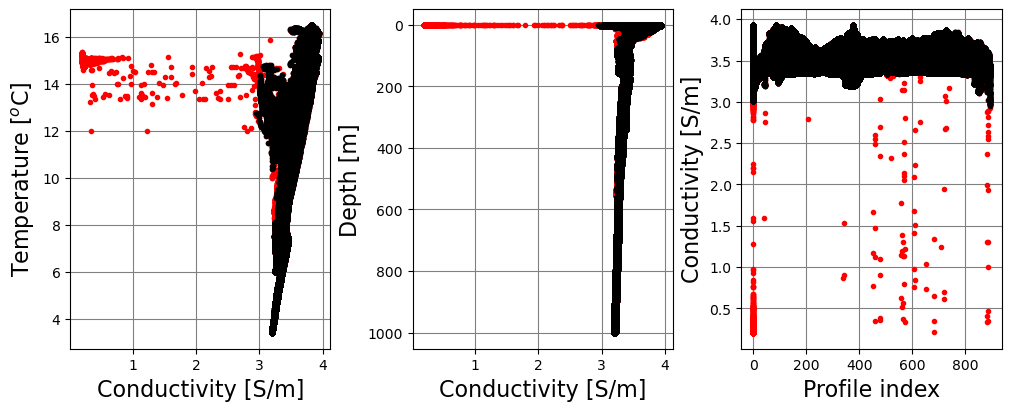

In [9]:
# Identify the questionable conductivity values
flag_stdev = 5 #number of standard deviations to temporarily flag bad salinity values 
clean_stdev = 3 #number of standard deviations to flag bad conductivity values, after removing the temporary bad values from the calc
dT = 50 #size of the profile bins
dz = 5 #size of the depth bins

ts0 = pgs.get_timeseries(filepath, deploy_name)
ts0.conductivity[ts0.conductivity<0.1] = np.nan
ts = pgs.get_conductivity_clean(ts0, dT, dz, flag_stdev, clean_stdev, accuracy)

# Figures to look at the comparison    
fig, ax = plt.subplots(1,3,figsize=(10,4), constrained_layout=True)

ax[0].plot(ts.conductivity, ts.temperature, color='r', marker='.', linestyle='none', label='Removed')
ax[0].plot(ts.conductivityClean, ts.temperature, color='k', marker='.', linestyle='none', label='Retained')
ax[0].set_ylabel('Temperature [$^o$C]', fontsize=16)
ax[0].set_xlabel('Conductivity [S/m]', fontsize=16)
ax[0].grid(axis='both', color='0.5')

ax[1].plot(ts.conductivity, ts.depth, color='r', marker='.', linestyle='none')
ax[1].plot(ts.conductivityClean, ts.depth, color='k', marker='.', linestyle='none')
ax[1].set_xlabel('Conductivity [S/m]', fontsize=16)
ax[1].set_ylabel('Depth [m]', fontsize=16)
ax[1].invert_yaxis()
ax[1].grid(axis='both', color='0.5')

ax[2].plot(ts.profile_index, ts.conductivity, color='r', marker='.', linestyle='none')
ax[2].plot(ts.profile_index, ts.conductivityClean, color='k', marker='.', linestyle='none')
ax[2].set_xlabel('Profile index', fontsize=16)
ax[2].set_ylabel('Conductivity [S/m]', fontsize=16)
ax[2].grid(axis='both', color='0.5')

print('Temperature vs. conductivity (left), depth vs. conductivity (middle), '
      'and conductivity vs. profile index (right), '
      'with the red dots showing the unphysical values flagged as bad and removed:')

In [10]:
# SAVING INTERMEDIATE FILE TO NETCDF
# print("Saving conductivity files to netcdf")
ts.to_netcdf(f'./{deploy_name}_conductivityClean.nc')
# Save a gridded version as well
outfile = make_gridfiles(f'./{deploy_name}_conductivityClean.nc', '.', deployfile, fnamesuffix='condfilter')

Salinity, temperature, conductivity and density shown, with conductivity outliers removed from the salinity, conductivity and density fields:


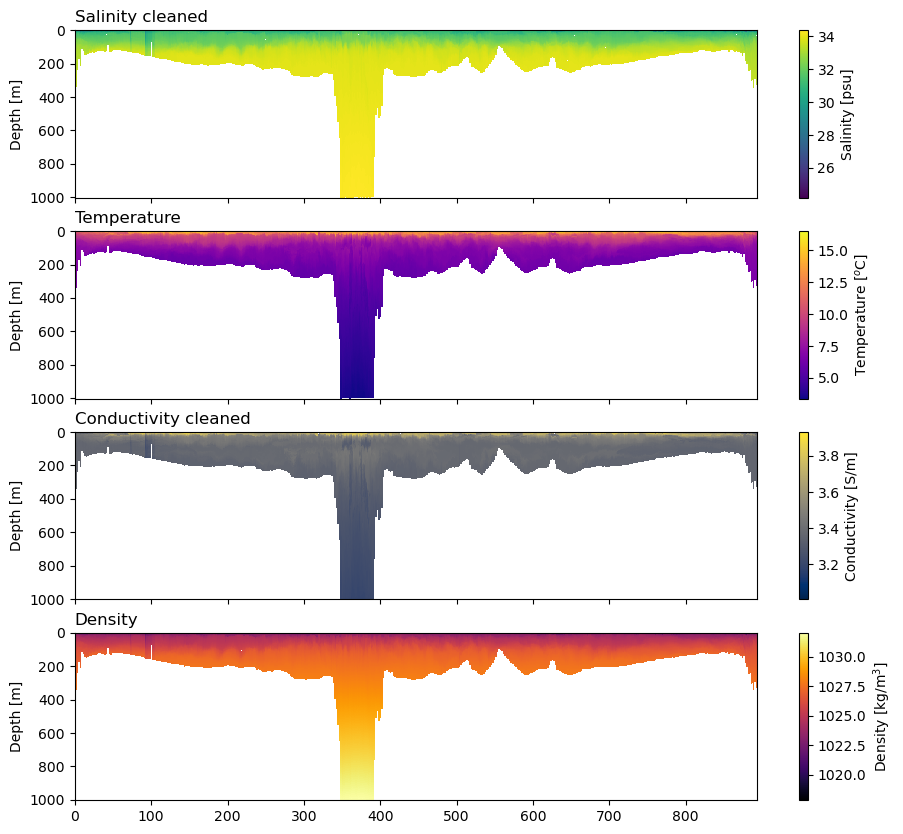

In [11]:
# Open the grid file
print('Salinity, temperature, conductivity and density shown, with conductivity outliers removed from the salinity, conductivity and density fields:')

ds=xr.open_dataset(f'./{deploy_name}_gridcondfilter.nc')
# list(ds.keys())

# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(4, 1, figsize=(11, 10), sharey=True, sharex=True)

xlims = [0, NUM_PROFILES]
ylims = [MAX_DEPTH,0]

pc = axs[0].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True)
axs[0].set_ylim(ylims)
axs[0].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = 'Salinity [psu]')
axs[0].set_title('Salinity cleaned',loc='left')

pc = axs[1].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,cmap='plasma')
fig.colorbar(pc, ax=axs[1], label = 'Temperature [$^o$C]')
axs[1].set_title('Temperature',loc='left')

# from matplotlib import colors as c
# pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivity'],rasterized=True,cmap=c.ListedColormap(['r']))
pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivityClean'],rasterized=True,cmap='cividis')
fig.colorbar(pc, ax=axs[2], label = 'Conductivity [S/m]')
axs[2].set_title('Conductivity cleaned',loc='left')

# pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['oxygen_concentration'],rasterized=True,cmap='inferno')
# fig.colorbar(pc, ax=axs[3])
# axs[3].set_title('Oxygen Concentration',loc='left')

pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['density'],rasterized=True,cmap='inferno')
fig.colorbar(pc, ax=axs[3], label = 'Density [kg/m$^3$]')
axs[3].set_title('Density',loc='left')

# fig.supylabel('Depth [m]')
axs[0].set_ylabel('Depth [m]');
axs[1].set_ylabel('Depth [m]');
axs[2].set_ylabel('Depth [m]');
axs[3].set_ylabel('Depth [m]');

When plotting the fields shown above with the conductivity filter, we can see that the salinity and conductivity fields now have "speckles" showing data removed. This filtering is applied to remove values from the following fields:

* conductivity
* salinity (re-calculated)
* density (re-calculated)

The new field is called **conductivityClean**. The other fields mentioned were replaced.


## 2.2 Identifying questionable salinity profiles

Here, potentially suspicious salinity profiles are identified in order to prevent them from being used in the thermal lag correction. While these questionable salinity profiles are not included in the following steps, these profiles **are not removed** from the final corrected salinity product.

In [12]:
SKIP_SENSOR_ALIGN=True

if SKIP_SENSOR_ALIGN == True:
    # print("Skipped sensor alignment correction")
    # ds0 = ts.copy(deep=True)
    # ds0 = ds0.where(np.isfinite(ds0.temperature + ds0.conductivity), drop=False)
    # ds1 = ds0
    fname = f'./{deploy_name}_conductivityClean.nc'
    gridfname = f'{deploy_name}_gridcondfilter.nc'
    clean_cutoff = 0.1

# elif SKIP_SENSOR_ALIGN == False:
#     # Save to an intermediary netcdf
#     ds0.to_netcdf(deploy_prefix+deploy_name+'_pre-thermal.nc')
#     print('Corrected data saved to file: '+deploy_prefix+deploy_name+'_pre-thermal.nc')
#     ncprocess.make_gridfiles(deploy_prefix+deploy_name+'_pre-thermal.nc',deploy_prefix,deploy_prefix+'deployment.yml',fnamesuffix='_pre-thermal')
#     print('Gridfile created: '+deploy_prefix+deploy_name+'_grid_pre-thermal.nc')

#     fname=deploy_prefix+deploy_name+'_pre-thermal.nc'
#     gridfname=deploy_prefix+deploy_name+'_grid_pre-thermal.nc'

# print('Using files:')
# print(fname)
# print(gridfname)


In [13]:
# Determine time series mean temperature profile
ds=xr.open_dataset(gridfname) # Not loading delayed mode data - instead loading from intermediate files saved.

Tmean = ds['temperature'].mean(dim='time')
Tmean = Tmean.sortby(Tmean, ascending=True).where(np.isfinite(Tmean), drop=True)

# Identify the questionable salinity values
clean_profs = 0#110 #number of profiles to exclude from the start and end of the time series
flag_stdev = 4 #number of standard deviations to temporarily flag bad salinity values 
clean_stdev = 4 #number of standard deviations to flag bad salinity values, after removing the temporary bad values
clean_cutoff = 0.1 #fraction of bad salinity values required to label a profile as bad
dtbin = 10 #number of temperature bins

sal = pgs.get_salinity_grid(ds0, Tmean, clean_profs, flag_stdev, clean_stdev, clean_cutoff, dtbin)

sal.to_netcdf('SalinityGrid.nc')

bad_profiles = sal.profiles.where(sal.bad >= clean_cutoff, drop=True)
print('Profiles flagged as bad due to questionable salinity values:', bad_profiles.values)

Profiles flagged as bad due to questionable salinity values: [ -0.   1.   2.   3.   4.   5.   7.   9.  11.  43.  73.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 890. 892. 893.]


Binned salinity plotted as a function of temperature (left) and vs. profile index (right), 
 with the salinity profiles identified as bad due to questionable values and set to NaN shown in red and indicated by the red arrows at the top of the panel on the right:


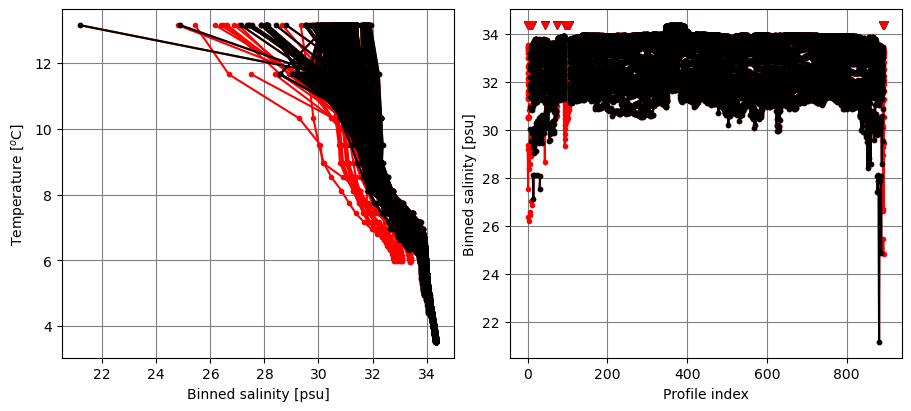

In [14]:
caption = ('Binned salinity plotted as a function of temperature '  
'(left) and vs. profile index (right), \n with the salinity profiles identified ' 
'as bad due to questionable values and set to NaN shown in red and indicated by '
'the red arrows at the top of the panel on the right:')

# Function to plot the salinity field with the values identified as bad
with xr.open_dataset('SalinityGrid.nc') as sal:    
    fig, ax = plt.subplots(1,2,figsize=(9,4), 
                           constrained_layout=True)
    
    sal.salinity.plot.line(ax=ax[0],
                           y='temperature',
                           color='r',
                           marker='.',
                           add_legend=False)
    sal.salinityGood.plot.line(ax=ax[0],
                                y='temperature',
                                color='k',
                                marker='.',
                                add_legend=False)
    ax[0].set_ylabel('Temperature [$^o$C]')
    ax[0].set_xlabel('Binned salinity [psu]')
    ax[0].grid(axis='both', color='0.5')
    
    sal.salinity.plot.line(ax=ax[1],
                           x='profiles',
                           color='r',
                           marker='.',
                           add_legend=False)
    sal.salinityGood.plot.line(ax=ax[1],
                                x='profiles',
                                color='k',
                                marker='.',
                                add_legend=False)
    ax[1].set_ylabel('Binned salinity [psu]')
    ax[1].set_xlabel('Profile index')
    ax[1].grid(axis='both', color='0.5')
    x = bad_profiles
    y = np.nanmax(sal.salinity.values) + np.zeros_like(bad_profiles)
    ax[1].scatter(x,y,30,marker='v',color='k',zorder=1)
    ax[1].scatter(x,y,25,marker='v',color='r',zorder=2)
    
    print(caption)

Temperature vs. salinity diagram.  Black contours give density in kg/m^3:


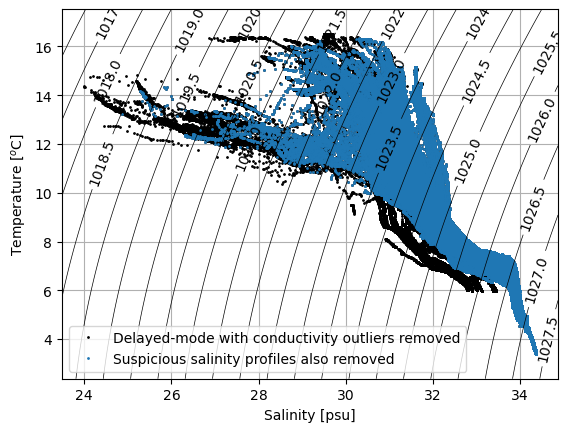

In [15]:
# T-S diagram to select near-surface water density range to exclude
# fname defined above
ts = xr.load_dataset(fname)#ds1.copy(deep=True)
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate
srate = stats.mode((np.diff(ts.time)).astype('timedelta64[s]')).mode

plt.plot(ts.salinity,ts.temperature,'k.',markersize=2, label = 'Delayed-mode with conductivity outliers removed')
# Now remove the bad profiles
idx = ~ts.profile_index.isin(bad_profiles)
plt.plot(ts.salinity[idx], ts.temperature[idx], '.', markersize = 2, label = 'Suspicious salinity profiles also removed')

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ts.salinity)-0.5, 
                      np.max(ts.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ts.temperature)-1, 
                      np.max(ts.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = plt.contour(S_range, T_range, density_grid,
                np.arange(1014,
                          np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.xlabel('Salinity [psu]')
plt.ylabel('Temperature [$^o$C]')
# plt.xlim(28,35)
plt.grid()
plt.legend(prop={'size': 10})
print('Temperature vs. salinity diagram. ',
     'Black contours give density in kg/m^3:')

In [16]:
display(Markdown('./docs/CTD_2_Sensor_lag.md'))

## 2.3 Sensor alignment correction

We now test application of a sensor alignment correction. In the literature this correction is often used to align the temperature and conductivity in time, relative to the pressure. This correction reduces the occurrence of salinity spikes near sharp gradients in T and S, and ensures calculations are made using the same parcel of water for all variables.
The misalignment between the sensors is caused by:
1. The physical separation between sensors causing a transit time delay for water being pumped through the CTD, and,
2. Different sensor response times

**Janzen and Creed (2011)** provided constants used for the GPCTD sensor alignment correction "... based on the transit time between the T-C sensors, the temperature response time, and the estimated response time of the conductivity sensor in a 10 ml/s flow." For their Sea-Bird GPCTD alignment corrections, temperature was advanced by +0.5 s relative to pressure, and conductivity was advanced by +0.4 s relative to pressure, with a sampling rate of 1 Hz. In prior processing, offset values for conductivity and temperature were preferentially used from Janzen and Creed, 2011. However, their glider had differing geometry from the SeaExplorers and Slocums used by C-PROOF. 

Instead, we directly estimate the sensor alignment correction constant for conductivity relative to temperature, $\tau_C$. We apply a preliminary correction using a linear time interpolation method, based on the one in the Sea-Bird CTD data processing manual and the Sea-Bird CTD-processing toolbox on Github 
(https://github.com/rejectedbanana/Sea-Bird-Toolbox/blob/master/CTD_PROCESSING/SBE_alignCTDW.m). We determine the correction using only water below the highly variable near-surface layer, which is approximately identified using the T-S diagram below. We choose as an isopycnal cutoff a value above the main thermocline, but which excludes that highly variable surface layer.

**To directly estimate the sensor alignment correction constant** following the methodology of Ferrari and Rudnick (2000):

1. Assume conductivity is approximately linearly related to temperature
2. Calculate the cross-spectrum between the standardized temperature and conductivity timeseries 
3. Calculate the coherence, to determine where the cross-spectrum is valid
4. Fit the function $2 \pi f \tau_C$ to the phase of the cross-spectrum, where $f$ is frequency and $\tau_C$ is the correction constant we are looking for

These steps are applied to each individual profile, with fresh surface water **less dense than a threshold** excluded based on the T-S diagram. The cross-spectrum is estimated using Welch's method, with a Hann window of **length 128 and 50% overlap**. The spectrogram (below) shows only values for which the coherence is **at least 75%** and exceeds the 95% confidence level. The choice of 75% is arbitrary, and results are not sensitive to this choice within the range 50% to 90%. 

In [17]:
badprofiles = sal.bad.profiles

Excluding data less dense than: 1023.0
Examining filename: ./dfo-bb046-20220707_conductivityClean.nc
Applying density cutoff
Total number of profiles: 893
Ready to loop over profiles
******
Spectrogram for T and C cross-spectrum magnitude (top), phase (middle), and squared coherence (bottom) as a function 
of frequency and profile index. Only points exceeding the 95% confidence level and with coherence above 75% are shown:


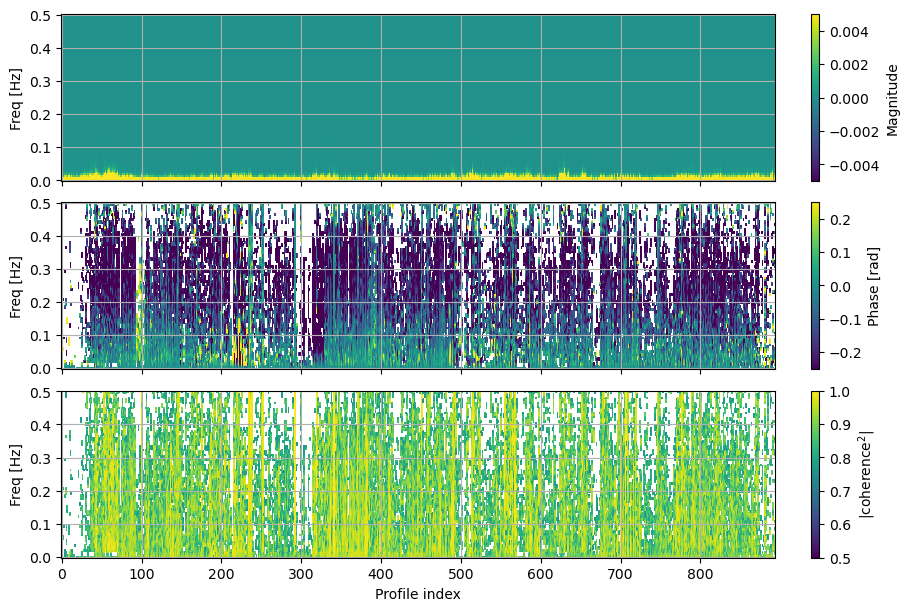

In [18]:
# #Set up the important constants for the analysis
n = 128 #segment length for ffts
density_cutoff = 1023. #exclude everything less dense than this from the minimization
print(f'Excluding data less dense than: {density_cutoff}')
num_profs = int(np.nanmax(ts.profile_index)) #number of profiles to include in the subset of data
clean_profs_start = 0 #number of profiles to exclude from the start
clean_profs_end = 0 #number of profiles to exclude from the end
c_val = 0.75 #our cutoff value for coherence as a fraction of 1
fs = 1/srate.astype(float) #the sampling frequency = 1/(delta t)
freq = np.linspace(0,0.50,100)*fs #frequency range to interpolate onto for plotting

#Spectrogram with density cutoff for chosen subset of profiles
fname = f'./{deploy_name}_conductivityClean.nc'
print(f'Examining filename: {fname}')

mag_all, phase_all, coh_all, profile_bins = pgs.get_spectrogram(
    fname, n, density_cutoff, clean_profs_start, 
    clean_profs_end, num_profs, fs, c_val, freq, bad_profiles
)

fig, axs = plt.subplots(nrows=3, ncols=1, 
                            constrained_layout=True, 
                            figsize=(9, 6), sharex=True)
print('******')
c0 = axs[0].pcolor(profile_bins, freq, mag_all, vmin=-0.005, vmax=0.005, rasterized=True);
cb = plt.colorbar(c0,ax=axs[0])
cb.set_label('Magnitude')
axs[0].set_ylabel('Freq [Hz]')
axs[0].grid()

c1 = axs[1].pcolor(profile_bins, freq, phase_all, vmin=-0.25, vmax=0.25, rasterized=True);
cb1 = plt.colorbar(c1,ax=axs[1])
cb1.set_label('Phase [rad]')
axs[1].set_ylabel('Freq [Hz]')
axs[1].grid()

c2 = axs[2].pcolor(profile_bins, freq, coh_all, vmin=0.5, vmax=1.0, rasterized=True);
cb2 = plt.colorbar(c2,ax=axs[2])
cb2.set_label('|coherence$^2$|')
axs[2].set_ylabel('Freq [Hz]')
axs[2].set_xlabel('Profile index')
axs[2].grid()

print('Spectrogram for T and C cross-spectrum magnitude (top), '
      'phase (middle), and squared coherence (bottom) '
      'as a function \nof frequency and profile index. Only points exceeding '
      'the 95% confidence level and with coherence above 75% are shown:') 

******
The value of tau_C is -0.14961 with standard error 0.00072.
******
Cross-spectrum phase of temperature and conductivity plotted as small gray points, with the mean plotted as large dots coloured by mean squared-coherence. 
The gray envelope shows the standard error for the mean over all profiles. The red line shows the function fit to points for which the frequency is less than the chosen cutoff:


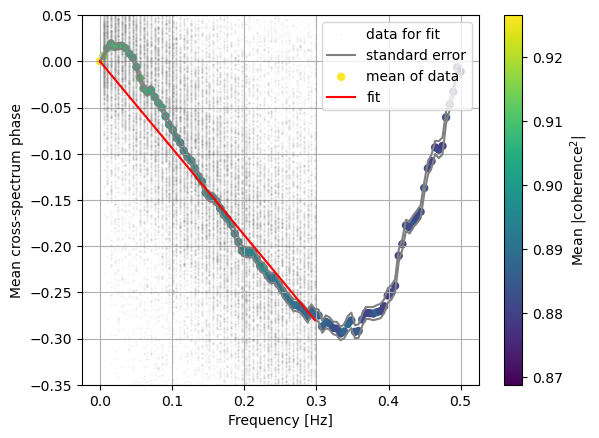

In [19]:
# Calcuate tau_C and plot the fit
freq_cut = 0.3
tau_C, covariance, fr_fld, fld, fit_y = pgs.get_tau_C(freq, freq_cut, fs, phase_all)

SE = np.sqrt(np.diag(covariance))
SE_A = SE[0]
print('******')
print(f'The value of tau_C is {tau_C:.5f} with standard error {SE_A:.5f}.')
print('******')

std_err = np.nanstd(phase_all,axis=1)/np.sqrt(np.shape(phase_all)[1])
plt.plot(fr_fld,fld,'.',color='gray',markersize=1,alpha=0.1,label='data for fit')
plt.plot(freq, np.nanmean(phase_all,axis=1)+std_err, '-', color='gray', 
         label='standard error')
plt.plot(freq, np.nanmean(phase_all,axis=1)-std_err, '-', color='gray')
plt.scatter(freq, np.nanmean(phase_all,axis=1), 25, np.nanmean(coh_all,axis=1), 
            label='mean of data')
plt.ylim(-0.35,0.05)
ax = plt.plot(fr_fld, fit_y, '-r', label='fit')
cb = plt.colorbar()
cb.set_label('Mean |coherence$^2$|')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean cross-spectrum phase')
plt.grid()
plt.legend()
print('Cross-spectrum phase of temperature and conductivity plotted ' 
      'as small gray points, with the mean plotted as large dots coloured by '
      'mean squared-coherence. \nThe gray envelope shows the standard error for '
      'the mean over all profiles. The red line shows the function fit to points '
      'for which the frequency is less than the chosen cutoff:')

In [20]:
# Apply alignment correction. This linear interpolation approach is taken from the Sea-Bird
# CTD-processing toolbox on Github 
# (https://github.com/rejectedbanana/Sea-Bird-Toolbox/blob/master/CTD_PROCESSING/SBE_alignCTDW.m)
# fname = 'conductivityClean.nc'
# print(fname)
advance_C = tau_C
advance_T = 0.00001#0.5

ds1 = pgs.alignment_correction(fname, srate, advance_C, advance_T)

# Save the adjusted conductivity as a gridded .nc file
ds1.to_netcdf(f'./{deploy_name}_cond_advance.nc')

# import pyglider.ncprocess as ncprocess
outfile = make_gridfiles(f'./{deploy_name}_cond_advance.nc', '.', deployfile, fnamesuffix='cond_advance')

In [21]:
dsbefore = xr.open_dataset(f'./{deploy_name}_gridcondfilter.nc')
dsgrid = xr.open_dataset(f'./{deploy_name}_gridcond_advance.nc')
# dsbefore.close()
# dsgrid.close()
dsgrid['salinity_diff'] = dsgrid['salinity']-dsbefore['salinity']
dsgrid['temp_diff'] = dsgrid['temperature']-dsbefore['temperature']

Salinity before (top) and after (middle) shifting the conductivity by -0.14960687122368954. The difference is shown on the bottom:


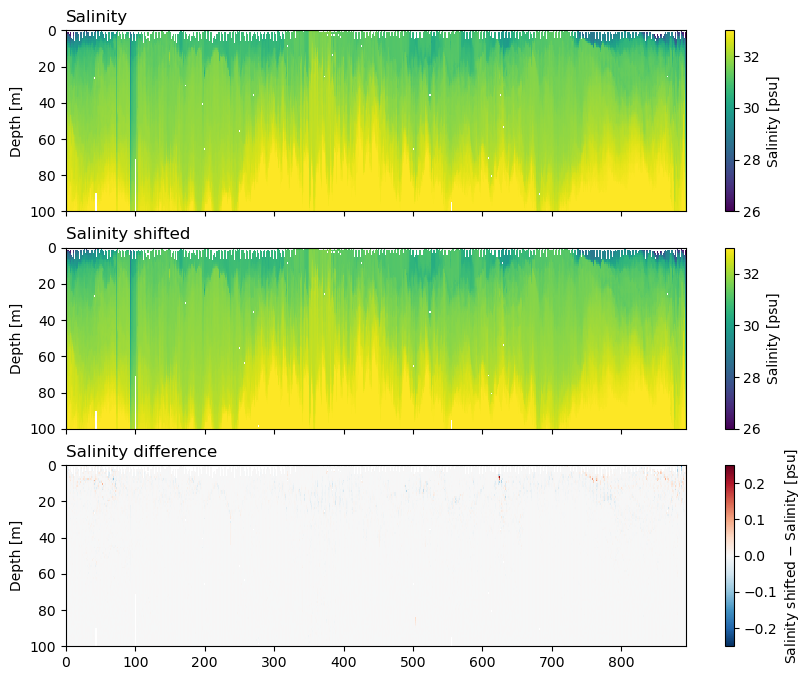

In [22]:
# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

xlims = [0, NUM_PROFILES]
ylims=[100,0]

pc = axs[0].pcolormesh(dsbefore.profile, dsbefore.depth, dsbefore['salinity'], rasterized=True, vmin=26,vmax=33)
axs[0].set_ylim(ylims)
axs[0].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = 'Salinity [psu]')
axs[0].set_title('Salinity',loc='left')

pc = axs[1].pcolormesh(dsgrid.profile, dsgrid.depth, dsgrid['salinity'], rasterized=True, vmin=26,vmax=33)
fig.colorbar(pc, ax=axs[1], label = 'Salinity [psu]')
axs[1].set_title('Salinity shifted',loc='left')

clims = [-0.25, 0.25]
pc = axs[2].pcolormesh(dsgrid.profile, dsgrid.depth, dsgrid.salinity_diff, rasterized=True,cmap = 'RdBu_r', 
                      vmin=clims[0],vmax=clims[1])
fig.colorbar(pc, ax=axs[2], label = 'Salinity shifted $-$ Salinity [psu]')
axs[2].set_title('Salinity difference',loc='left')

axs[0].set_ylabel('Depth [m]');
axs[1].set_ylabel('Depth [m]');
axs[2].set_ylabel('Depth [m]');

print(f'Salinity before (top) and after (middle) shifting the conductivity by {advance_C}. The difference is shown on the bottom:')

Temperature vs. salinity diagram (left), where black contours give density in kg/m^3. On the right, the difference between the 
aligned and uncorrected temperature vs. the difference between the aligned and uncorrected salinity is shown:


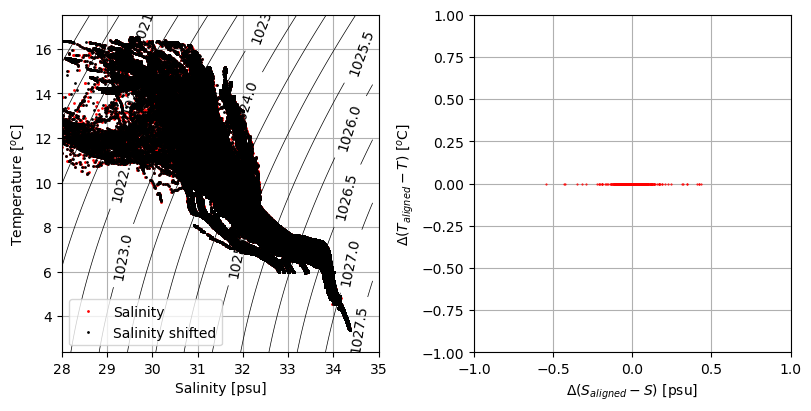

In [23]:
# T-S diagram showing correction magnitude
ds1 = xr.load_dataset(f'./{deploy_name}_cond_advance.nc')
ds0 = xr.load_dataset(f'./{deploy_name}_conductivityClean.nc')

fig, ax = plt.subplots(nrows=1, ncols=2, 
                            constrained_layout=True, 
                            figsize=(8, 4))

ax[0].plot(ds0.salinity,ds0.temperature,'r.',markersize=2, label = 'Salinity', rasterized=True)
ax[0].plot(ds1.salinity,ds1.temperature,'k.',markersize=2, label = 'Salinity shifted', rasterized=True)
#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ds1.salinity)-0.5, 
                      np.max(ds1.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ds1.temperature)-1, 
                      np.max(ds1.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = ax[0].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[0].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[0].set_xlabel('Salinity [psu]')
ax[0].set_ylabel('Temperature [$^o$C]')
ax[0].set_xlim(28,35)
ax[0].grid()
ax[0].legend()

# ds0 = ts.copy(deep=True)
ds0 = ds0.where(np.isfinite(ds0.temperature + 
                            ds0.conductivity), drop=True)

ax[1].plot(ds1.salinity-ds0.salinity,ds1.temperature-ds0.temperature,'r.',markersize=1, rasterized=True)
ax[1].set_xlabel('$\\Delta (S_{aligned} - S$) [psu]')
ax[1].set_ylabel('$\\Delta (T_{aligned} - T$) [$^o$C]')
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].grid()
print('Temperature vs. salinity diagram (left), where black contours give density in kg/m^3. On the right, the difference between the \naligned and uncorrected temperature vs. the difference between the aligned and uncorrected salinity is shown:')

In [24]:
# IF THERE'S NO DIFFERENCE THEN I'M REMOVING THIS PLOT

# # Compare data before after alignment correction is applied
# # ds1 = corrected, ds0 = uncorrected
# ds0 = xr.load_dataset(f'./{deploy_name}_conductivityClean.nc')
# ds1 = xr.load_dataset(f'./{deploy_name}_cond_advance.nc')
# ds0 = ds0.where(np.isfinite(ds0.temperature + 
#                             ds0.conductivity), drop=False)

# N = len(ds0.time)
# todo = slice(int(N/2)-351000, int(N/2)-348500)
# todo = slice(int(N/2)-348500, int(N/2)-330000)
# todo = slice(int(N/2)-320000, int(N/2)-300000)
# # todo = slice(528525,700000)

# fig, axs = plt.subplots(nrows=1, ncols=4, 
#                         constrained_layout=True, 
#                         figsize=(9, 3))

# ds = ds0.isel(time=todo)

# # Uncorrected as well
# axs[0].plot(ds.temperature, ds.pressure, 'o-r', markersize=2,label='uncorrected')
# axs[1].plot(ds.conductivityClean, ds.pressure, 'o-r', markersize=2)
# axs[2].plot(ds.salinity, ds.pressure, 'o-r', markersize=2)

# ds = ds1.isel(time=todo)
# axs[0].plot(ds.temperature, ds.pressure, 'o-', markersize=2,label='sensor drift adjust')
# axs[1].plot(ds.conductivityClean, ds.pressure, 'o-', markersize=2)
# axs[2].plot(ds.salinity, ds.pressure, 'o-', markersize=2)

# # ds = ds0.isel(time=todo).salinity_corrected.values-ds0.isel(time=todo).salinity.values
# # axs[3].plot(ds, ds0.isel(time=todo).pressure, '.-r', markersize=2)
# ds = ds1.isel(time=todo).salinity.values-ds0.isel(time=todo).salinity.values
# axs[3].plot(ds, ds0.isel(time=todo).pressure, '.-', markersize=2)
# y_lim=[30, 0]
# axs[0].set_ylim(y_lim)
# axs[0].set_xlim([9, 15])
# axs[0].set_ylabel('Pressure [dbar]')
# axs[0].set_xlabel('Temperature [$^o$C]')
# axs[0].grid()
# # axs[0].legend(fontsize=16);

# axs[1].set_ylim(y_lim)
# axs[1].set_xlim([3.4, 4])        
# axs[1].set_ylabel('Pressure [dbar]')
# axs[1].set_xlabel('Conductivity [S/m]')
# axs[1].grid()

# axs[2].set_ylim(y_lim)
# axs[2].set_xlim([31, 32.2])
# axs[2].set_ylabel('Pressure [dbar]')
# axs[2].set_xlabel('Salinity [psu]')
# axs[2].grid() 

# axs[3].set_ylim(y_lim)
# axs[3].set_ylabel('Pressure [dbar]')
# axs[3].set_xlabel('$\\Delta$ Salinity: Aligned - Uncorrected [psu]')
# axs[3].grid() 

# # print('Upcast and downcast of temperature, conductivity, and salinity vs. pressure, '
# #      'for part of the upper water column. Black indicates uncorrected fields, and '
# #      'blue indicates fields for which an alignment has been applied. Final panel shows '
# #       'the difference between the aligned and uncorrected salinity.')

We fit the function only to frequencies **below 0.3 Hz** (above). Above this frequency, we lose coherence and the slope of the cross-spectrum phase changes sign. We see that the resulting value for the **time constant $\tau_C$** is well within the required $\pm 0.5$ s of the value specified for Sea-Bird GPCTDs, $\tau_C = -0.1$ s. 

Previously, Janzen and Creed (2011) constants would be used instead of our directly estimated value for $\tau_C$, since we have found that the direct estimate is sensitive to the choices of frequency and density cutoff used, with reasonable choices producing constants that can vary by up to $\pm 0.5$ s. However, as we see here, the conductivity and thus salinity changes are very small, leading us to decide **not to apply sensor alignment adjustment to this glider mission**.

In [25]:
display(Markdown('./docs/CTD_2_Thermal_lag_Calvert.md'))

## 2.4 Thermal lag correction

The thermal lag effect is caused by the thermal inertia of the conductivity cell affecting the temperature of the water as it passes through the cell. To determine the thermal lag correction, the temperature inside the conductivity cell is estimated, then salinity is recalculated using the estimated temperature and the measured conductivity. To estimate the temperature, a recursive filter is applied to the temperature field with parameters 𝛼 (the amplitude of the error), and 𝜏 (the time constant for the thermal lag). Two methods for this are mentioned below.

Sea-Bird GPCTDs are pumped with a constant flow rate. As such, we expect the thermal lag to be approximately constant over the full mission, and it is sufficient to find a single value of 𝛼 and 𝜏 for the entire mission. It is ideal to use profile pairs from regions with large temperature gradients, but small conductivity gradients, when comparing up- and down-casts.

Janzen and Creed (2011) determined a cell thermal mass correction for the GPCTD using data from a prototype CTD that sampled twice as rapidly as the GPCTD nominally samples, with a pumped flow rate of 10 ml/s. **They found 𝛼 = 0.06 and 𝜏 = 10s.** These values are considered when retrieving $\alpha$ and $\tau$ to see how much the results differ.

This mission on the **Calvert Line** occurred in a highly energetic environment, so near-surface differences between a downcast and the subsequent upcast are likely to be caused by spatiotemporal variability. As such, we exclude segments of each profile in the upper water column for which the **density is $<$1023 kg/m$^3$** from the minimization routine.

#### Considerations for using Janzen and Creed values:

Prior processing used Janzen and Creed (2011) values $\alpha$ and $\tau$ for the thermal lag. For each mission, the thermal lag parameters were directly estimated. The steps are outlined below, but can be found in much greater detail here: **https://cproof.uvic.ca/gliderdata/deployments/reports/C-PROOF_SBE_CTDProcessingReport_v0.2.pdf**

* It was confirmed that the directly estimated value of $\tau$ was within $\pm$10s of the Janzen and Creed (2011) value of 10s
* The improvement with the directly estimated, as well as Janzen and Creed, parameters was quantified.
* The thermal lag correction was applied with the parameters that resulted in the greater improvement, and did not result in an over-correction.
* If a given sensor had a directly estimated value of $\tau$ that is significantly higher or lower than 10s, investigate further

Note that the thermal lag correction parameters are more likely to vary slightly between individual GPCTD sensors than the alignment correction constants. 

With this method, the recursive filter seeks to minimize the root-mean squared difference (RMSD), which is calculated as the square root of the sum of the squared areas between pairs of salinity profiles (binned by temperature), normalized by the number of pairs of profiles. The values of 𝛼 and 𝜏 that minimize the area between pairs of profiles (each dive and subsequent climb along the glider path) were determined using a brute force minimization scheme. This method also uses a subset of the remaining data, consisting of **100 pairs of profiles** equally spaced in time, to determine the correction. 

While this was employed during previous processing, **here we are preferring to directly estimate the parameters** using a mission-specific subset of profiles. However, the results are still compared to Janzen and Creed values.

#### Updated thermal lag correction procedure:

Same to the above, this is based on Morison et al's (2011) second method which derives a modified temperature that is the "best guess" for what the temperature is in the conductivity cell based on the temperature observed by the thermistor.  The temperature is corrected using `lfilter` which is just a recursive filter:

$T_T(n) = -b T_T(n-1) + aT(n) - a T(n-1)$

where

$$ a = \frac{4f_n\alpha \tau}{1+4f_n\tau} $$

and 
$$ b = 1 - \frac{2a}{\alpha}$$

$\tau$ can be thought of as the time constant of the thermal lag (in seconds) and $\alpha$ as its strength.  Following Gaurau et al, $f_n$ is the sampling frequency. The cell temperature is then"

$$T_c(n) = T(n) - T_T(n)$$

and can be used to calculate salinity with the measured conductivity and pressure. 


### 2.4.1 Pre-processing steps:

We **exlude** profiles from the correction for which the area between subsequent downcasts is more than one standard deviation from the mission mean. This ensures that no data crossing fronts or intrusions is included in the correction, in line with the key assumption that a downcast and the subsequent upcast be identical. 

Furthermore, we impose a cutoff for the area between pairs of profiles that will be included in the subset used to estimate the parameters. Any pair of profiles whose area is more than 3 standard deviations away from the mean will be excluded from the determination of the RMSD. This ensures that a small number of anomalous profiles do not bias the results.

During this step, the **suspicious salinity profiles** identified earlier are excluded as well.



In [26]:
# Set up our constants
fn = 0.5*fs #frequency for Sea-Bird GPCTD
density_cutoff = 1023 #exclude everything less dense than this from the minimization
num_profs = 100 #number of profiles to include in the subset of data # This is not used for the correction, but is used in the q/c steps
clean_profs_start = 0 #110#50 #number of profiles to exclude from the start
clean_profs_end = 0 #50 #number of profiles to exclude from the end
dn_stdev = 1 #how many standard deviations from the mean the area between downcasts can be

# Load time series
print(f'Loading filename {fname}')
ts = xr.load_dataset(fname)#ds1.copy(deep=True)
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate
tot_profs = int(np.nanmax(ts.profile_index.values))
print('Total number of profiles:', tot_profs)

# Overwrite conductivity in our working xarray with the clean, aligned conductivity field
ts['conductivity'] = ts.conductivityClean

Loading filename ./dfo-bb046-20220707_conductivityClean.nc
Total number of profiles: 893


In [27]:
# print('Calculating profile pairs')
ts_sub, profile_bins, profile_bins_all, direction = pgs.profile_pairs(
    ts, clean_profs_start, clean_profs_end, num_profs, bad_profiles
)

# Identify boolean index for application of density cutoff 
density_bool = ts_sub.density>=density_cutoff

In [28]:
#Determine the RMSD for the subset of profiles with no corrections applied
# print('Calculating profiles to exclude based on large standard deviation')
alpha_0 = 0
tau_0 = 0
area_bad = np.full_like(profile_bins_all, False, dtype=bool)

#Run brute force optimization that applies the TS_diff function to dataset ts_sub
RMSD_0 = pgs.TS_diff((alpha_0, tau_0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub) 
# print(f'...')
area_0, p_ind_0 = pgs.TS_diff((alpha_0, tau_0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

print('RMSD for uncorrected data = ', RMSD_0)

RMSD for uncorrected data =  0.4099214002349775


In [29]:
#Determine the area between subsequent downcasts to restrict profiles included
print(f'Restricting profiles')
dn_area, area_bad = pgs.TS_preprocess(
    density_bool, dn_stdev, 
    profile_bins, profile_bins_all, 
    direction, ts_sub)
print('Max and min area between downcasts = ', np.nanmax(dn_area), np.nanmin(dn_area))

ts_bad = ts_sub.where(
    ts_sub.profile_index.isin(
        profile_bins_all[area_bad]), 
        drop=True)
prof_list = ts_bad.profile_index
print('List of profiles to exclude:', np.unique(prof_list.values))


Restricting profiles
Max and min area between downcasts =  5.362305736199261 0.0004152601135410483
List of profiles to exclude: [ 45.  46.  51.  52.  53.  54.  69.  70. 198. 199. 200. 201. 290. 291.
 292. 293. 294. 295. 296. 297. 328. 329. 334. 335. 336. 337. 350. 351.
 352. 353. 360. 361. 382. 383. 386. 387. 388. 389. 427. 428. 441. 442.
 489. 490. 493. 494. 501. 502. 503. 504. 569. 570. 585. 586. 589. 590.
 621. 622. 633. 634. 635. 636. 717. 718. 874. 875. 878. 879.]


In [30]:
ts_sub['profiles_to_exclude'] = ts_sub.profile_index.isin(prof_list.values)

Red indicates profile pairs that were identified in this process, where the area between 
profile pairs was considered to be too large, and so are not included in the thermal lag correction. 
White bands indicate salinity profiles removed during step 2.2.


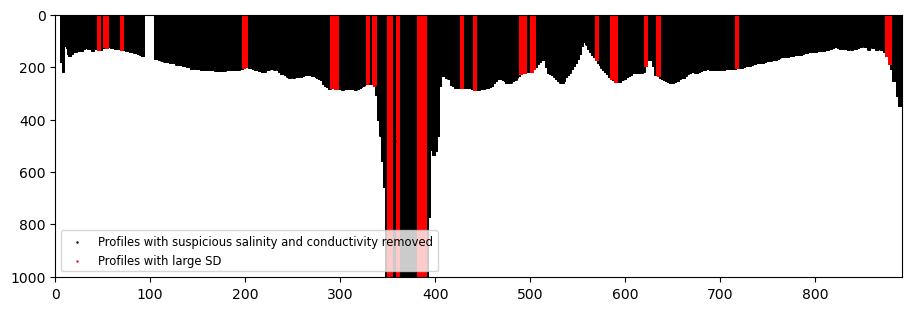

In [31]:
# Plot the profiles that were kept for the comparison!!
print('Red indicates profile pairs that were identified in this process, where the area between \nprofile pairs was considered to be too large, and so are not included in the thermal lag correction. \nWhite bands indicate salinity profiles removed during step 2.2.')

subdata = ts_sub.where(ts_sub.profiles_to_exclude == True) #profile_index.isin(prof_list.values)#(profile_bins)

fig, ax = plt.subplots(1,1, figsize=(9, 3), constrained_layout=True)

ax.scatter(ts_sub.profile_index, ts_sub.pressure, marker = '.', color='black', s = 2,
           rasterized=True, label='Profiles with suspicious salinity and conductivity removed')

ax.set_ylim([MAX_DEPTH, 0])
ax.set_xlim([0,np.nanmax(ts_sub.profile_index)])

ax.scatter(subdata.profile_index, subdata.pressure,
           color='red', marker = '.', s=2, rasterized=True, label = 'Profiles with large SD')

ax.legend(fontsize='small', loc='lower left');

In [32]:
# Could save the pre-processed variables as intermediate files as well??
# ts_sub

# SAVING INTERMEDIATE FILE TO NETCDF
# print("Saving thermal lag preprocessing files to netcdf")
ts_sub.to_netcdf(f'{deploy_name}_goodprofiles.nc')
# Save a gridded version as well
outfile = make_gridfiles(f'{deploy_name}_goodprofiles.nc', '.', deployfile, fnamesuffix='goodprofiles')

### 2.4.2 Defining the range to calculate  $\alpha$ and $\tau$:

From examining the asymmetry in up-down profiles, we manually choose a range to apply the thermal lag correction to. It is ideal to pick areas with high temperature gradients in the water column, but generally low salinity gradients.

In [33]:
fname = f'{deploy_name}_goodprofiles.nc'
gridfname= f'{deploy_name}_gridgoodprofiles.nc'

Density cutoff: 1023
Uncorrected salinity (top), shown with suspicious profiles and low-density data points removed.
Salinity differences between sequential profiles, showing asymmetry between upcasts and downcasts:


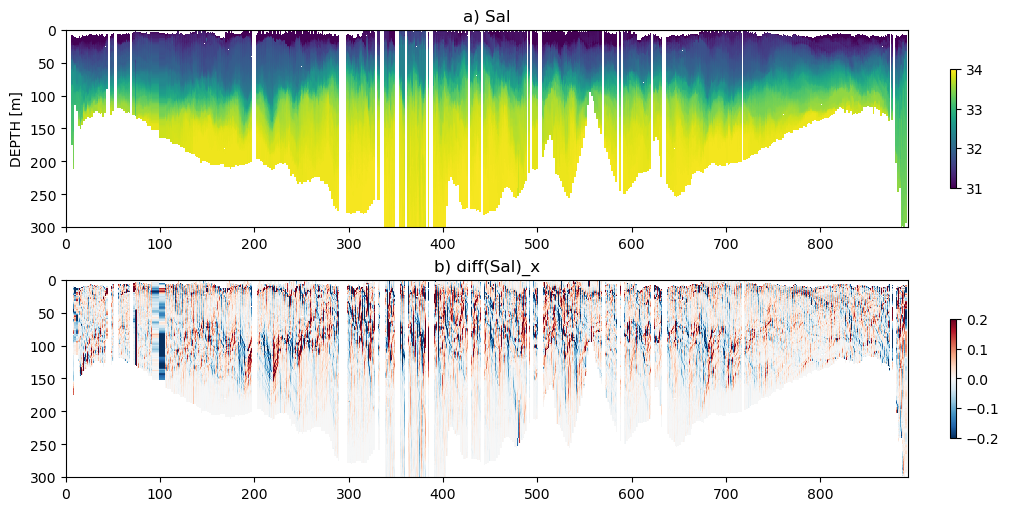

In [34]:
with (xr.open_dataset(gridfname) as ds, xr.open_dataset(fname) as ts):
    # print(f'Opening {gridfname} and {fname}')
    # profile_lims = [np.nanmin(ds.profile_index), NUM_PROFILES]
    profile_lims = [0, NUM_PROFILES]
    # print(f'Profile limits: {profile_lims}')    
    ds = ds.where((ds.profile >=profile_lims[0]) & (ds.profile <= profile_lims[1]), drop=True)
    
    # Also testing dropping the bad profiles
    ds = ds.where(ds.profiles_to_exclude==False)

    # Similarly, applying a density cutoff
    ds = ds.where(ds.density>=density_cutoff)
    print(f'Density cutoff: {density_cutoff}')

    # Figure
    
    Y_LIMS = [300, 0]
    
    fig, axs = plt.subplots(2, 1, height_ratios=[3, 3], figsize = [10,5],
                            layout='constrained', sharex=False)
    ax = axs[0]
    pc = ax.pcolormesh(ds.profile, ds.depth, ds.salinity, vmin=31, vmax=34)
    ax.set_ylim(Y_LIMS)
    ax.set_xlim(profile_lims)
    ax.set_ylabel('DEPTH [m]')
    ax.set_title('a) Sal')
    
    fig.colorbar(pc, ax=ax, shrink=0.6)
    ax = axs[1]
    pc = ax.pcolormesh(ds.profile[1:], ds.depth, ds.salinity.diff(dim='time'), vmax=0.2, vmin=-0.2, cmap='RdBu_r')
    ax.set_ylim(Y_LIMS)
    ax.set_xlim(profile_lims)
    ax.set_title('b) diff(Sal)_x')
    fig.colorbar(pc, ax=ax, shrink=0.6)
    # caption(f'Up-down asymetry to salinity.  Down casts have slightly higher salinity compared to upcasts,\nindicative of a thermal lag effect in the conductivity cell')

print('Uncorrected salinity (top), shown with suspicious profiles and low-density data points removed.')
print('Salinity differences between sequential profiles, showing asymmetry between upcasts and downcasts:')

Zooming in along the glider deployment to visualize up-down asymmetry:


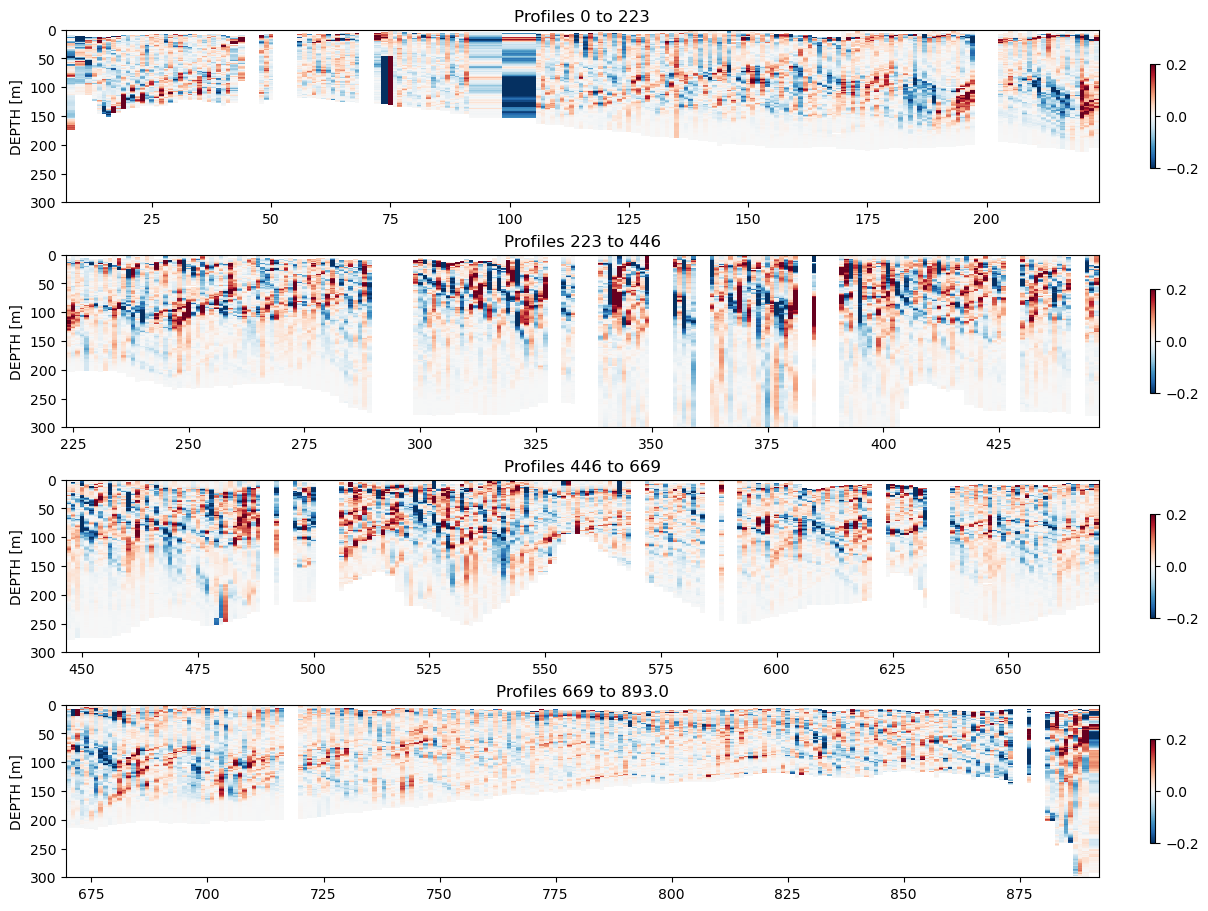

In [35]:
# Now adding zoomed plot
xlim_1 = [0, int(NUM_PROFILES/4)]
xlim_2 = [int(NUM_PROFILES/4), int(NUM_PROFILES/4*2)]
xlim_3 = [int(NUM_PROFILES/4*2), int(NUM_PROFILES/4*3)]
xlim_4 = [int(NUM_PROFILES/4*3), NUM_PROFILES]

Y_LIMS = [300, 0]

fig, axs = plt.subplots(4, 1, #height_ratios=[1, 4], 
                        figsize = [12,9],
                        layout='constrained', sharex=False)

# ax = axs[0]
# ax.plot(ds_sub.profile_index, ds_sub.profile_direction, '.')
# ax.set_xlim(profile_lims)
# ax.set_ylabel('Dir')
# ax.set_title('c) Zoomed direction, Down=+1') 

profile_lims = xlim_1
ds_sub = ds.where((ds.profile >=profile_lims[0]) & (ds.profile <= profile_lims[1]), drop=True)

ax = axs[0]
pc = ax.pcolormesh(ds_sub.profile[1:], ds_sub.depth, ds_sub.salinity.diff(dim='time'), vmax=0.2, vmin=-0.2, cmap='RdBu_r')
ax.set_ylim(Y_LIMS)
ax.set_title(f'Profiles {profile_lims[0]} to {profile_lims[1]}')
fig.colorbar(pc, ax=ax, shrink=0.6)
ax.set_ylabel('DEPTH [m]')

profile_lims = xlim_2
ds_sub = ds.where((ds.profile >=profile_lims[0]) & (ds.profile <= profile_lims[1]), drop=True)

ax = axs[1]
pc = ax.pcolormesh(ds_sub.profile[1:], ds_sub.depth, ds_sub.salinity.diff(dim='time'), vmax=0.2, vmin=-0.2, cmap='RdBu_r')
ax.set_ylim(Y_LIMS)
ax.set_title(f'Profiles {profile_lims[0]} to {profile_lims[1]}')
fig.colorbar(pc, ax=ax, shrink=0.6)
ax.set_ylabel('DEPTH [m]')

profile_lims = xlim_3
ds_sub = ds.where((ds.profile >=profile_lims[0]) & (ds.profile <= profile_lims[1]), drop=True)

ax = axs[2]
pc = ax.pcolormesh(ds_sub.profile[1:], ds_sub.depth, ds_sub.salinity.diff(dim='time'), vmax=0.2, vmin=-0.2, cmap='RdBu_r')
ax.set_ylim(Y_LIMS)
ax.set_title(f'Profiles {profile_lims[0]} to {profile_lims[1]}')
fig.colorbar(pc, ax=ax, shrink=0.6)
ax.set_ylabel('DEPTH [m]')

profile_lims = xlim_4
ds_sub = ds.where((ds.profile >=profile_lims[0]) & (ds.profile <= profile_lims[1]), drop=True)

ax = axs[3]
pc = ax.pcolormesh(ds_sub.profile[1:], ds_sub.depth, ds_sub.salinity.diff(dim='time'), vmax=0.2, vmin=-0.2, cmap='RdBu_r')
ax.set_ylim(Y_LIMS)
ax.set_title(f'Profiles {profile_lims[0]} to {profile_lims[1]}')
fig.colorbar(pc, ax=ax, shrink=0.6)
ax.set_ylabel('DEPTH [m]');
print('Zooming in along the glider deployment to visualize up-down asymmetry:')

Ranges that appear to fulfill this requirement include:
* 110-170
* 440-480
* 570-620
* 630-670
* 720-765
* 800-830

In [36]:
# Select a subset of profiles to calculate tau and alpha
profile_lims = [720,765]
# profile_lims = [110,170]
# profile_lims = [591,620]

print(f'Using profile limits {profile_lims} for tau and alpha calculation')

Using profile limits [720, 765] for tau and alpha calculation


In [37]:
# grid = grid.where((grid.profile>=760) & (grid.profile<800), drop=True) # Using ds roughly filtered above
tbins = ds.temperature.mean(dim='time', skipna=True)
tbins = np.sort(tbins[::6])
tbins = tbins[np.isfinite(tbins)]
# print(tbins)
depbins = ds.depth[::6]

In [38]:
# Ok, here it switches back to the time series....
# switching ds to ts
with xr.load_dataset(fname) as ds0:
    # USING PROFILE_LIMS DECIDED ABOVE!
    # print(f'Loading {fname}')
    inds=np.arange(profile_lims[0], profile_lims[1])
    
    indbins = np.arange(inds[0]-0.5, inds[-1]+0.5, 1.0)
    
    ts = ds0.where((ds0.profile_index >= inds[0]) & (ds0.profile_index <= inds[-1]), drop=False)
    # Once again, make sure to use density cutoff
    ts = ts.where((ts.density > density_cutoff), drop=True)
    # Also, profiles to exclude:
    ts = ts.where(ts.profiles_to_exclude == False, drop=True)
    
    sal = ts.salinity

### Comparing the error measurements between estimated alpha & tau and Janzen and Creed values:

Below shows the subset of profiles, limited to 200 m depth, without any thermal lag correction, and using literature values (Janzen and Creed 2011). The Janzen and Creed $\alpha$ and $\tau$ values visibly reduce the error in the water column, but better results can be retrieved by calculating our own.

In [39]:
# Comparison - correcting the salinity with the janzen and creed values, and comparing the error before and after
dt = ts.time.diff(dim='time').mean(dim='time').astype('float') / 1e9
fn = 1.0 / dt
alpha = 0.06
tau = 10.0

sal = pgs.correct_sal(ts, fn, alpha, tau)

# ss0 is an array
ss0, err0, totalerr = pgs.get_error(ts, ts.salinity, tbins, indbins)
ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)

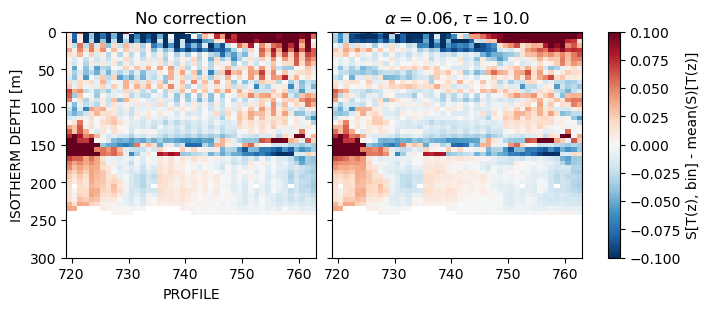

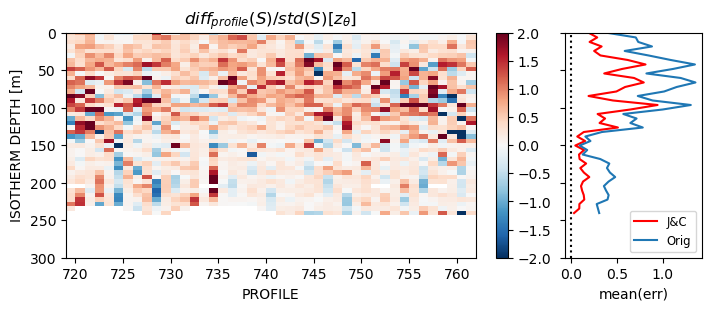

In [40]:
sp0 = np.nanmean(ss0, axis=1)

Y_LIMS = [300,0]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained',figsize = [7,3])
pc = ax[0].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss0-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[0].set_ylim(Y_LIMS)
ax[0].set_ylabel('ISOTHERM DEPTH [m]')
ax[0].set_xlabel('PROFILE')
ax[0].set_title('No correction')

pc = ax[1].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_title(f'$\\alpha = {alpha}, \\tau = {tau}$')
fig.colorbar(pc, ax=ax, label='S[T(z), bin] - mean(S)[T(z)]')

fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], layout='constrained', sharey=True,figsize = [7,3])
pc = axs[0].pcolormesh(indbins[:-2], depbins[:len(tbins)-1][::-1], err, vmin=-2, vmax=2, cmap='RdBu_r')
axs[0].set_ylabel('ISOTHERM DEPTH [m]')
axs[0].set_ylim(Y_LIMS)
axs[0].set_xlabel('PROFILE')
axs[0].set_title('$diff_{profile}(S) / std(S)[z_{\\theta}]$')
fig.colorbar(pc, ax=axs[0])

axs[1].axvline(x=0, color='black',linestyle='dotted')
axs[1].plot(np.nanmean(err, axis=1), depbins[:len(tbins)-1][::-1], label='J&C', color='red')
axs[1].plot(np.nanmean(err0, axis=1), depbins[:len(tbins)-1][::-1], label='Orig')
axs[1].legend(fontsize='small')
axs[1].set_xlabel('mean(err)');


### Finding alpha and tau values with lowerest error estimates:

By scanning over a range of alpha and tau values, error minima can be retrieved. We can see that, below, from scanning for errors, there is a consistent band with lower error. We'll select the cell with lowest error and other minima nearby. 

In [41]:
## scan:
alphas = np.arange(0.02, 0.074, 0.0025)
taus = np.arange(10, 30, 0.5)
errors = np.zeros((len(alphas), len(taus)))
for ny, alpha in enumerate(alphas):
    for nx, tau in enumerate(taus):

        sal = pgs.correct_sal(ts, fn, alpha, tau)
        ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)
        errors[ny, nx] = np.nansum(np.nanmean(err, axis=1))

The range of alpha and tau values tested, with log10-transformed errors coloured. The dark blue indicates the alpha and tau with lowest errors:


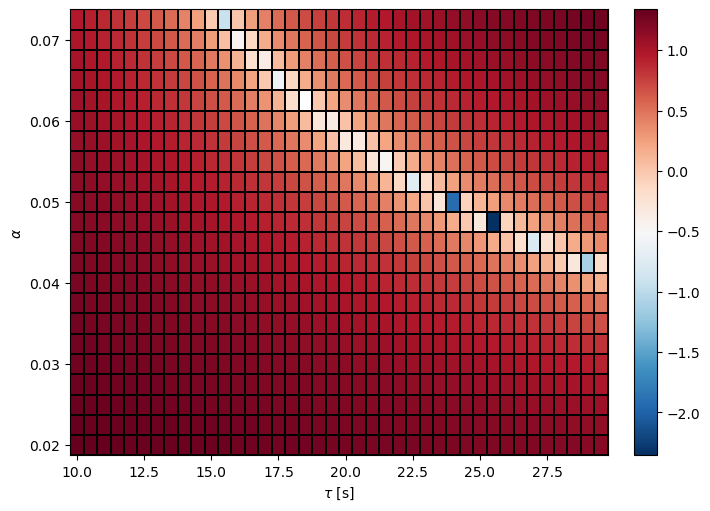

In [42]:
fig, ax = plt.subplots(layout='constrained',  figsize = [7,5])
pc = ax.pcolormesh(taus, alphas, np.log10(errors-np.min(errors[:])),
                   cmap='RdBu_r', edgecolors='k', rasterized=True, linewidth = 0.1) #, vmin=0, vmax=12)#, vmin=-2, vmax=2)
fig.colorbar(pc)
ax.set_xlabel('$\\tau$ [s]')
ax.set_ylabel('$\\alpha$')
ind = np.argmin(errors[:])

errorviz=np.log10(errors-np.min(errors[:]))
ind = np.where(errorviz==np.nanmin(errorviz))
# This doesn't get the right tau value with this index. It gets a -Inf value in this case. Will have to return to it.

print('The range of alpha and tau values tested, with log10-transformed errors coloured. The dark blue indicates the alpha and tau with lowest errors:')

### Applying determined alpha and tau for futher validation

The following plots show the application of these tau and alpha values to the beginning, end, and entire glider mission. The Janzen and Creed error statistics, as well as errors from no correction applied, are shown as well.

#### Applied to the end of the mission:

******
Applying alpha = 0.0475 and tau = 25.5
*****


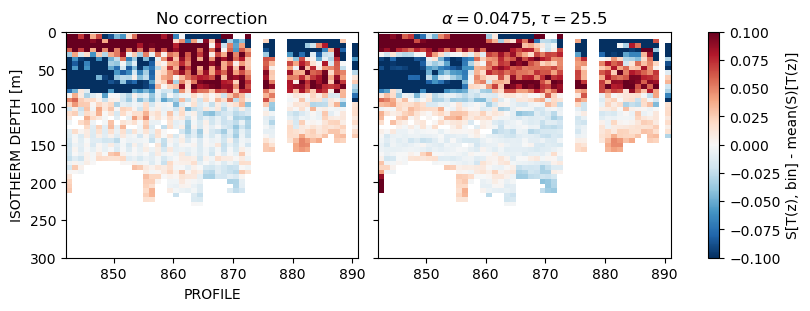

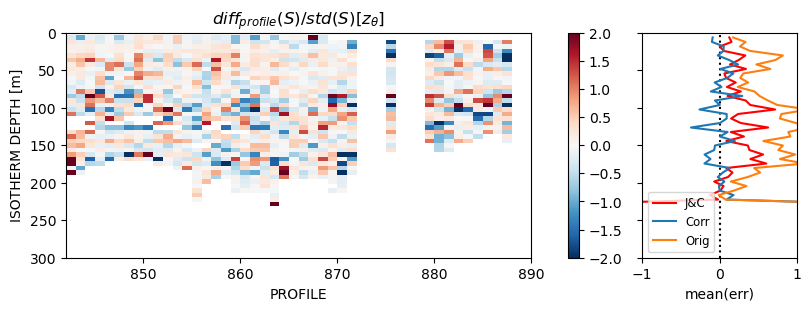

In [43]:
dt = ts.time.diff(dim='time').mean(dim='time').astype('float') / 1e9
fn = 1.0 / dt
alpha = 0.0475#0.055
tau = 25.5#21.5

print('******')
print(f'Applying alpha = {alpha} and tau = {tau}')
print('*****')

alpha2 = 0.06
tau2 = 10

with xr.load_dataset(fname) as ts0:
    inds = np.arange(NUM_PROFILES-50, NUM_PROFILES)
    # inds=np.arange(profile_lims[0], profile_lims[1])
    
    indbins = np.arange(inds[0]-0.5, inds[-1]+0.5, 1.0)
    
    ts = ts0.where((ts0.profile_index >= inds[0]) & (ts0.profile_index <= inds[-1]), drop=False)
    # Once again, make sure to use density cutoff? maybe?
    ts = ts.where((ts.density > density_cutoff), drop=True)
    # Also, profiles to exclude:
    ts = ts.where(ts.profiles_to_exclude == False, drop=True)
    
    sal = pgs.correct_sal(ts, fn, alpha, tau)
    
    ss0, err0, totalerr = pgs.get_error(ts, ts.salinity, tbins, indbins)
    ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)

    sal2 = pgs.correct_sal(ts, fn, alpha2, tau2)
    ss2, err2, totalerr2 = pgs.get_error(ts, sal2, tbins, indbins)


Y_LIMS = [300,0]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize = [8,3])
sp0 = np.nanmean(ss0, axis=1)
pc = ax[0].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss0-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_ylim(Y_LIMS)
ax[0].set_ylabel('ISOTHERM DEPTH [m]')
ax[0].set_xlabel('PROFILE')
ax[0].set_title('No correction')
ax[0].set_ylim(Y_LIMS)

pc = ax[1].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_title(f'$\\alpha = {alpha}, \\tau = {tau}$')
fig.colorbar(pc, ax=ax, label='S[T(z), bin] - mean(S)[T(z)]')

fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], layout='constrained', sharey=True, figsize = [8,3])
pc = axs[0].pcolormesh(indbins[:-2], depbins[:len(tbins)-1][::-1], err, vmin=-2, vmax=2, cmap='RdBu_r')
axs[0].set_ylim(Y_LIMS)
axs[0].set_ylabel('ISOTHERM DEPTH [m]')
axs[0].set_xlabel('PROFILE')
axs[0].set_title('$diff_{profile}(S) / std(S)[z_{\\theta}]$')
fig.colorbar(pc, ax=axs[0])

ERR_LIM = [-1, 1]
axs[1].axvline(x=0, color='black',linestyle='dotted')
axs[1].plot(np.nanmean(err2, axis=1), depbins[:len(tbins)-1][::-1], label='J&C', color = 'red')
axs[1].plot(np.nanmean(err, axis=1), depbins[:len(tbins)-1][::-1], label='Corr')
axs[1].plot(np.nanmean(err0, axis=1), depbins[:len(tbins)-1][::-1], label='Orig')
axs[1].set_xlim(ERR_LIM)
axs[1].legend(fontsize='small', loc='lower left')
axs[1].set_xlabel('mean(err)');


#### Applied to the beginning of the mission:


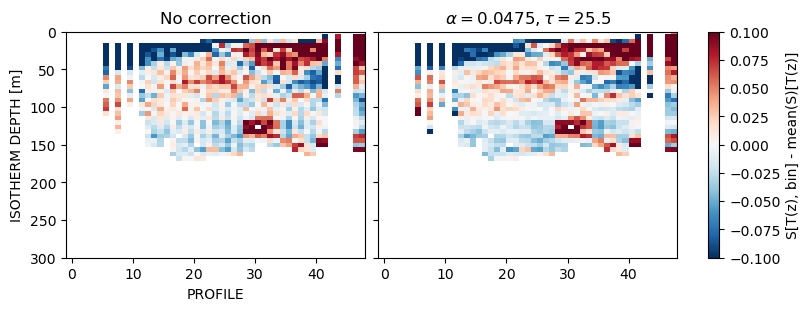

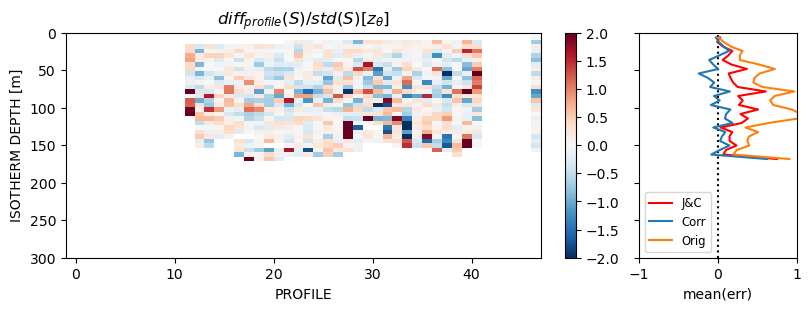

In [44]:
with xr.load_dataset(fname) as ts0:
    inds = np.arange(0,50)
    
    indbins = np.arange(inds[0]-0.5, inds[-1]+0.5, 1.0)
    
    ts = ts0.where((ts0.profile_index >= inds[0]) & (ts0.profile_index <= inds[-1]), drop=False)
    # Once again, make sure to use density cutoff? maybe?
    ts = ts.where((ts.density > density_cutoff), drop=True)
    # Also, profiles to exclude:
    ts = ts.where(ts.profiles_to_exclude == False, drop=True)
    
    sal = pgs.correct_sal(ts, fn, alpha, tau)
    
    ss0, err0, totalerr = pgs.get_error(ts, ts.salinity, tbins, indbins)
    ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)

    sal2 = pgs.correct_sal(ts, fn, alpha2, tau2)
    ss2, err2, totalerr2 = pgs.get_error(ts, sal2, tbins, indbins)


Y_LIMS = [300,0]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize= [8,3])
sp0 = np.nanmean(ss0, axis=1)
pc = ax[0].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss0-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_ylim([200, 0])
ax[0].set_ylabel('ISOTHERM DEPTH [m]')
ax[0].set_xlabel('PROFILE')
ax[0].set_title('No correction')
ax[0].set_ylim(Y_LIMS)

pc = ax[1].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_title(f'$\\alpha = {alpha}, \\tau = {tau}$')
fig.colorbar(pc, ax=ax, label='S[T(z), bin] - mean(S)[T(z)]')

fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], layout='constrained', sharey=True, figsize = [8,3])
pc = axs[0].pcolormesh(indbins[:-2], depbins[:len(tbins)-1][::-1], err, vmin=-2, vmax=2, cmap='RdBu_r')
axs[0].set_ylim(Y_LIMS)
axs[0].set_ylabel('ISOTHERM DEPTH [m]')
axs[0].set_xlabel('PROFILE')
axs[0].set_title('$diff_{profile}(S) / std(S)[z_{\\theta}]$')
fig.colorbar(pc, ax=axs[0])

ERR_LIM = [-1, 1]
axs[1].axvline(x=0, color='black',linestyle='dotted')
axs[1].plot(np.nanmean(err2, axis=1), depbins[:len(tbins)-1][::-1], label='J&C', color = 'red')
axs[1].plot(np.nanmean(err, axis=1), depbins[:len(tbins)-1][::-1], label='Corr')
axs[1].plot(np.nanmean(err0, axis=1), depbins[:len(tbins)-1][::-1], label='Orig')
axs[1].set_xlim(ERR_LIM)
axs[1].legend(fontsize='small', loc='lower left')
axs[1].set_xlabel('mean(err)');


### Middle of the mission

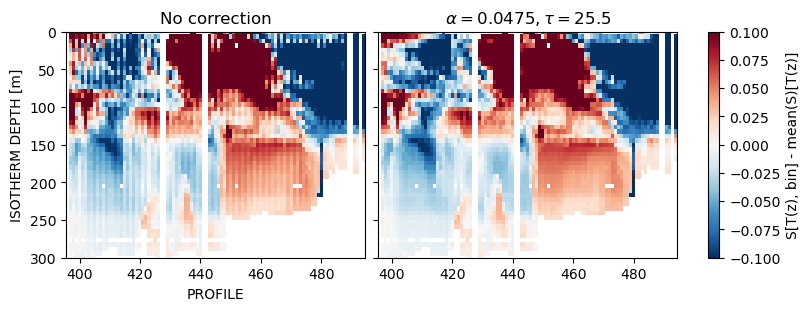

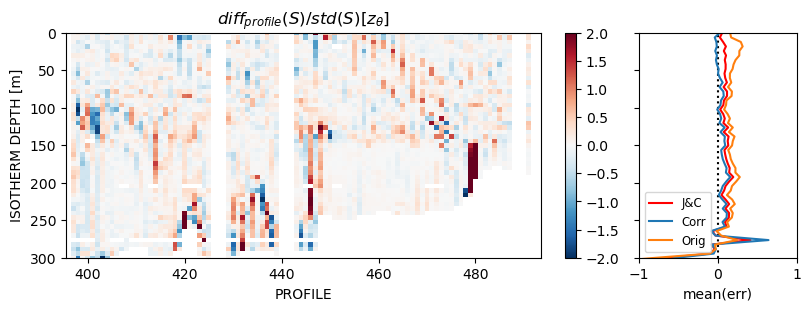

In [45]:
with xr.load_dataset(fname) as ts0:
    inds = np.arange((NUM_PROFILES/2)-50, (NUM_PROFILES/2)+50)
    
    indbins = np.arange(inds[0]-0.5, inds[-1]+0.5, 1.0)
    
    ts = ts0.where((ts0.profile_index >= inds[0]) & (ts0.profile_index <= inds[-1]), drop=False)
    # Once again, make sure to use density cutoff? maybe?
    ts = ts.where((ts.density > density_cutoff), drop=True)
    # Also, profiles to exclude:
    ts = ts.where(ts.profiles_to_exclude == False, drop=True)
    
    sal = pgs.correct_sal(ts, fn, alpha, tau)
    
    ss0, err0, totalerr = pgs.get_error(ts, ts.salinity, tbins, indbins)
    ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)

    sal2 = pgs.correct_sal(ts, fn, alpha2, tau2)
    ss2, err2, totalerr2 = pgs.get_error(ts, sal2, tbins, indbins)


Y_LIMS = [300,0]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize= [8,3])
sp0 = np.nanmean(ss0, axis=1)
pc = ax[0].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss0-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_ylim([200, 0])
ax[0].set_ylabel('ISOTHERM DEPTH [m]')
ax[0].set_xlabel('PROFILE')
ax[0].set_title('No correction')
ax[0].set_ylim(Y_LIMS)

pc = ax[1].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_title(f'$\\alpha = {alpha}, \\tau = {tau}$')
fig.colorbar(pc, ax=ax, label='S[T(z), bin] - mean(S)[T(z)]')

fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], layout='constrained', sharey=True, figsize = [8,3])
pc = axs[0].pcolormesh(indbins[:-2], depbins[:len(tbins)-1][::-1], err, vmin=-2, vmax=2, cmap='RdBu_r')
axs[0].set_ylim(Y_LIMS)
axs[0].set_ylabel('ISOTHERM DEPTH [m]')
axs[0].set_xlabel('PROFILE')
axs[0].set_title('$diff_{profile}(S) / std(S)[z_{\\theta}]$')
fig.colorbar(pc, ax=axs[0])

ERR_LIM = [-1, 1]
axs[1].axvline(x=0, color='black',linestyle='dotted')
axs[1].plot(np.nanmean(err2, axis=1), depbins[:len(tbins)-1][::-1], label='J&C', color = 'red')
axs[1].plot(np.nanmean(err, axis=1), depbins[:len(tbins)-1][::-1], label='Corr')
axs[1].plot(np.nanmean(err0, axis=1), depbins[:len(tbins)-1][::-1], label='Orig')
axs[1].set_xlim(ERR_LIM)
axs[1].legend(fontsize='small', loc='lower left')
axs[1].set_xlabel('mean(err)');


#### Finally, applied to the overall mission:

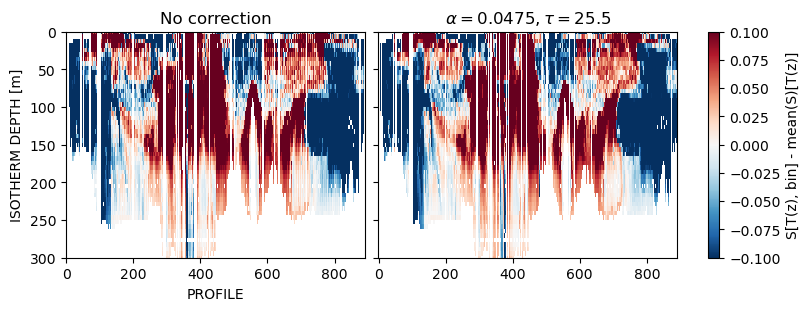

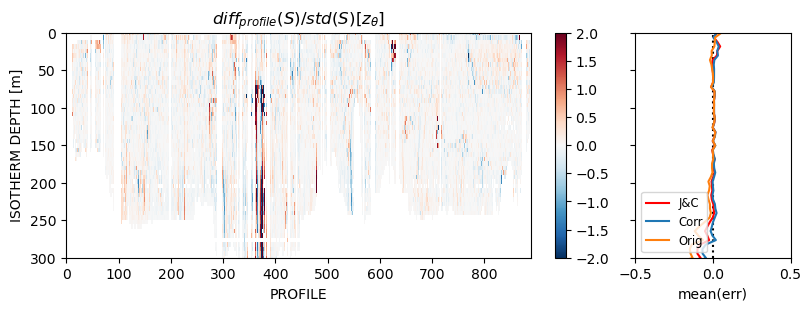

In [46]:
with xr.load_dataset(fname) as ts0:
    inds = np.arange(0, NUM_PROFILES)
    
    indbins = np.arange(inds[0]-0.5, inds[-1]+0.5, 1.0)
    
    ts = ts0.where((ts0.profile_index >= inds[0]) & (ts0.profile_index <= inds[-1]), drop=False)
    # Once again, make sure to use density cutoff? maybe?
    ts = ts.where((ts.density > density_cutoff), drop=True)
    # Also, profiles to exclude:
    ts = ts.where(ts.profiles_to_exclude == False, drop=True)
    
    sal = pgs.correct_sal(ts, fn, alpha, tau)
    
    ss0, err0, totalerr = pgs.get_error(ts, ts.salinity, tbins, indbins)
    ss, err, totalerr = pgs.get_error(ts, sal, tbins, indbins)

    sal2 = pgs.correct_sal(ts, fn, alpha2, tau2)
    ss2, err2, totalerr2 = pgs.get_error(ts, sal2, tbins, indbins)


Y_LIMS = [300,0]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize = [8,3])
sp0 = np.nanmean(ss0, axis=1)
pc = ax[0].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss0-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_ylim([200, 0])
ax[0].set_ylabel('ISOTHERM DEPTH [m]')
ax[0].set_xlabel('PROFILE')
ax[0].set_title('No correction')
ax[0].set_ylim(Y_LIMS)

pc = ax[1].pcolormesh(indbins[:-1], depbins[:len(tbins)-1][::-1], ss-sp0[:, np.newaxis], cmap='RdBu_r', vmin=-0.1, vmax=0.1) #, vmin=3.34, vmax=3.52)
ax[1].set_title(f'$\\alpha = {alpha}, \\tau = {tau}$')
fig.colorbar(pc, ax=ax, label='S[T(z), bin] - mean(S)[T(z)]')

fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], layout='constrained', sharey=True, figsize = [8,3])
pc = axs[0].pcolormesh(indbins[:-2], depbins[:len(tbins)-1][::-1], err, vmin=-2, vmax=2, cmap='RdBu_r')
axs[0].set_ylim(Y_LIMS)
axs[0].set_ylabel('ISOTHERM DEPTH [m]')
axs[0].set_xlabel('PROFILE')
axs[0].set_title('$diff_{profile}(S) / std(S)[z_{\\theta}]$')
fig.colorbar(pc, ax=axs[0])

ERR_LIM = [-.5, .5]
axs[1].axvline(x=0, color='black',linestyle='dotted')
axs[1].plot(np.nanmean(err2, axis=1), depbins[:len(tbins)-1][::-1], label='J&C', color = 'red')
axs[1].plot(np.nanmean(err, axis=1), depbins[:len(tbins)-1][::-1], label='Corr')
axs[1].plot(np.nanmean(err0, axis=1), depbins[:len(tbins)-1][::-1], label='Orig')
axs[1].set_xlim(ERR_LIM)
axs[1].legend(fontsize='small', loc='lower left')
axs[1].set_xlabel('mean(err)');


In [47]:
print('*****')
print(f'Saving with alpha = {alpha} and tau = {tau} applied')
print('*****')

# We're going to apply the changes to the un-filtered data. That step happened last here:

fname = f'./{deploy_name}_conductivityClean.nc'
gridfname = f'{deploy_name}_gridcondfilter.nc'

*****
Saving with alpha = 0.0475 and tau = 25.5 applied
*****


In [48]:
ts.close()
ds.close()

In [49]:
with xr.open_dataset(fname) as ts:
    display(ts)
    ts['conductivity'] = ts.conductivityClean
    s, t, d = pgs.correct_sal_temp_dens(ts, fn, alpha, tau)
    ts['salinity_corrected'] = ('time', s)
    ts['temperature_adjusted'] = ('time', t)
    ts['density_adjusted'] = ('time', d)
    # fix attributes
    ts.to_netcdf(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_thermal_lag.nc')
    display(ts)

outfile = make_gridfiles(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_thermal_lag.nc', 
                         f'{filepath}/{glider_name}/{deploy_name}', 
                         deployfile, fnamesuffix='_thermal_lag')

<xarray.Dataset>
Dimensions:                (time: 1759051)
Coordinates:
  * time                   (time) datetime64[ns] 2022-07-07T16:45:19.20499993...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
Data variables: (12/19)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    conductivity           (time) float64 ...
    temperature            (time) float64 ...
    pressure               (time) float64 ...
    ...                     ...
    profile_direction      (time) float64 ...
    salinity               (time) float64 ...
    potential_density      (time) float64 ...
    density                (time) float64 ...
    potential_temperature  (time) float64 ...
    conductivityClean      (time) float64 ...
Attributes: (12/67)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Calvert Island deployment
    contributor_name:          James Pegg, Jody Klymak, Tetjana Ross, Jennife...
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC as part...
    time_coverage_end:         2022-07-28T03:28:20.381000000
    time_coverage_start:       2022-07-07T16:45:19.205000000
    title:                     dfo-bb046-20220707T1645
    transmission_system:       IRIDIUM
    wmo_id:                    4803918

<xarray.Dataset>
Dimensions:                (time: 1759051)
Coordinates:
  * time                   (time) datetime64[ns] 2022-07-07T16:45:19.20499993...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
Data variables: (12/22)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    conductivity           (time) float64 3.306 nan nan nan ... nan nan nan nan
    temperature            (time) float64 13.6 14.76 14.61 ... 15.18 15.18 15.18
    pressure               (time) float64 -0.1 1.17 1.41 ... -0.31 -0.31 -0.31
    ...                     ...
    density                (time) float64 ...
    potential_temperature  (time) float64 ...
    conductivityClean      (time) float64 ...
    salinity_corrected     (time) float64 27.61 nan nan nan ... nan nan nan nan
    temperature_adjusted   (time) float64 12.96 14.08 13.95 ... 15.18 15.18
    density_adjusted       (time) float64 1.021e+03 nan nan nan ... nan nan nan
Attributes: (12/67)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Calvert Island deployment
    contributor_name:          James Pegg, Jody Klymak, Tetjana Ross, Jennife...
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC as part...
    time_coverage_end:         2022-07-28T03:28:20.381000000
    time_coverage_start:       2022-07-07T16:45:19.205000000
    title:                     dfo-bb046-20220707T1645
    transmission_system:       IRIDIUM
    wmo_id:                    4803918

### Before and after plots of the thermal lag correction

The **following plots** show the adjusted salinity, temperature, and density, respectively. The insets, right, correspond to the <font color='red'>**red box**</font>, delineating the profile range used to calculate the alpha and tau values. Further, unadjusted salinity, temperature, and density outliers, identified during the pre-processing steps, which were removed for the tau and alpha calculation to not skew results, are shaded in a lighter colour.

These fields, adjusted and re-calculated using the new alpha and tau values, are saved in the output file as fields **salinity**, **temperature** and **density**. The original delayed-mode, uncorrected fields are saved as **salinity0**, **temperature0** and **density0**.

In [50]:
# Open the grid file
ts=xr.load_dataset(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_thermal_lag.nc')

tsbad = xr.load_dataset(f'{deploy_name}_goodprofiles.nc')
# Also testing dropping the bad profiles
tsbad = tsbad.where(tsbad.profiles_to_exclude==False)

# Trying to make a mask of the good and bad data used to derive correction parameters from
ts['salinity_mask'] = ts.salinity.isin(tsbad.salinity)

# prof_lims=[profile_lims[0], profile_lims[0]+20]
# ts = ts.where((ts.profile_index >= prof_lims[0]) & (ts.profile_index <= prof_lims[1]), drop=True)


In [51]:
# Open the grid file
ds=xr.open_dataset(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_grid_thermal_lag.nc')
# list(ds.keys())
dsbad = xr.open_dataset(f'{deploy_name}_gridgoodprofiles.nc')

# idx = dsbad.where(dsbad.profiles_to_exclude ==True)
# dsbad.salinity[idx] = np.nan

# Also testing dropping the bad profiles
dsbad = dsbad.where(dsbad.profiles_to_exclude==False, drop=False)

# Similarly, applying a density cutoff
dsbad = dsbad.where(dsbad.density>=density_cutoff, drop = False)
print(f'Density cutoff: {density_cutoff}')

# Trying to make a mask of the good and bad data used to derive correction parameters from
ds['salinity_mask'] = ds.salinity.isin(dsbad.salinity)


Density cutoff: 1023


Salinity before (top) and after adjustment (middle), with salinity difference (bottom).
Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.
The profile range used to determine the thermal lag correction is shown on the right:


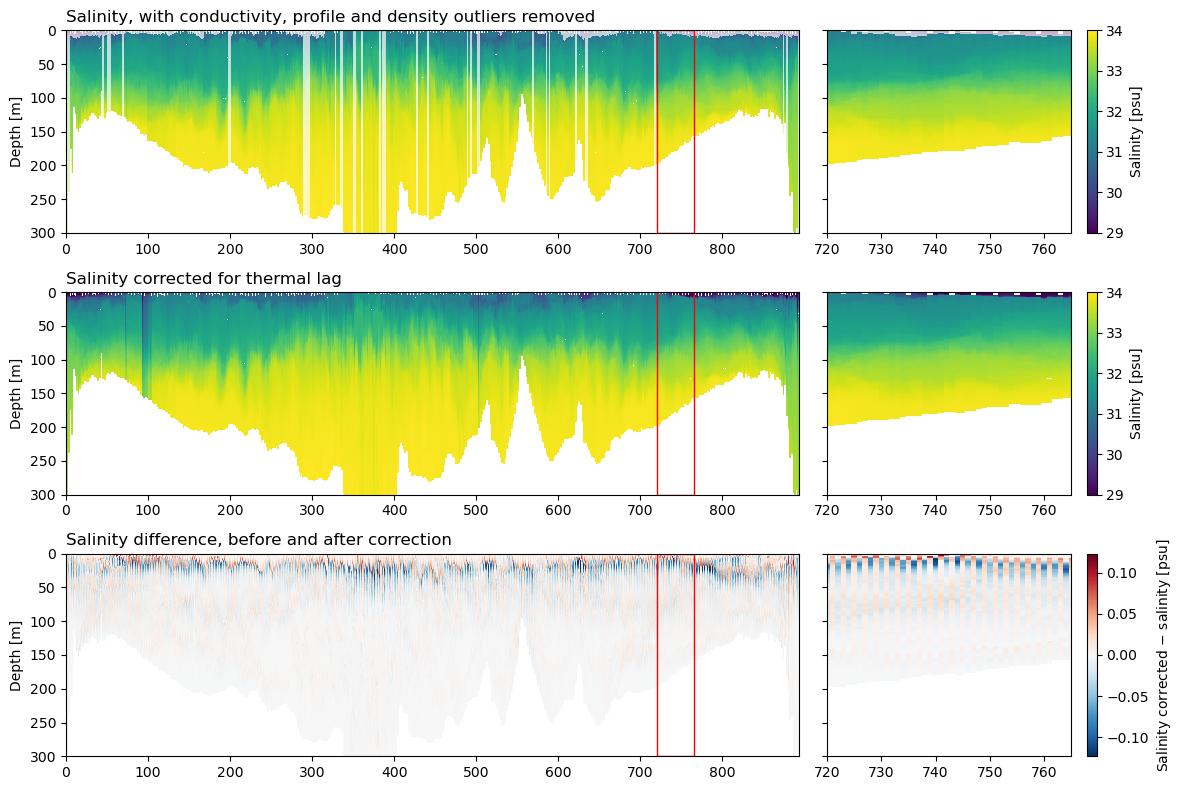

In [52]:
# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharey=True, width_ratios=[3,1.25], squeeze=True)

# Limits
xlims = [0, NUM_PROFILES]
ylims=[300,0] #[MAX_DEPTH,0]
sal_lims = [29,34]

# Rectangle showing area used to get alpha and tau
from matplotlib.patches import Rectangle
# print(f'Drawing rectangle centered at: {profile_lims[0], ylims[0]}')
# rect = #, linestyle='dotted'

pc = axs[0,0].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1], alpha = 0.3)
pc = axs[0,0].pcolormesh(dsbad.profile, dsbad.depth, dsbad['salinity'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1])
axs[0,0].set_ylim(ylims)
axs[0,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[0,0])
axs[0,0].set_ylabel('Depth [m]')
axs[0,0].set_title('Salinity, with conductivity, profile and density outliers removed',loc='left')
axs[0,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1));

pc = axs[1,0].pcolormesh(ds.profile, ds.depth, ds['salinity_corrected'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1])
axs[1,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[1,0])
axs[1,0].set_ylabel('Depth [m]')
axs[1,0].set_title('Salinity corrected for thermal lag',loc='left')
axs[1,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1));

maxdiff = abs(np.nanmax(ds['salinity_corrected']-ds['salinity']))
difflims = [maxdiff*-1, maxdiff]
# difflims= [-0.2,0.2]
pc = axs[2,0].pcolormesh(ds.profile, ds.depth, ds['salinity_corrected']-ds['salinity'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1])
axs[2,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[2,0])
axs[2,0].set_ylabel('Depth [m]')
axs[2,0].set_title('Salinity difference, before and after correction',loc='left')
axs[2,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1));

# Subplots from correction area

xlims = profile_lims
# Subplot from correction area
pc = axs[0,1].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1], alpha = 0.3)
pc = axs[0,1].pcolormesh(dsbad.profile, dsbad.depth, dsbad['salinity'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1])
axs[0,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0,1], label = 'Salinity [psu]')

pc = axs[1,1].pcolormesh(ds.profile, ds.depth, ds['salinity_corrected'],rasterized=True,vmin=sal_lims[0], vmax=sal_lims[1])
axs[1,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[1,1], label = 'Salinity [psu]')

pc = axs[2,1].pcolormesh(ds.profile, ds.depth, ds['salinity_corrected']-ds['salinity'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1])
axs[2,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[2,1], label = 'Salinity corrected $-$ salinity [psu]')
fig.tight_layout()

print('Salinity before (top) and after adjustment (middle), with salinity difference (bottom).')
print('Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.')
print('The profile range used to determine the thermal lag correction is shown on the right:')

Temperature before (top) and after adjustment (middle), with temperature difference (bottom).
Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.
The profile range used to determine the thermal lag correction is shown on the right:


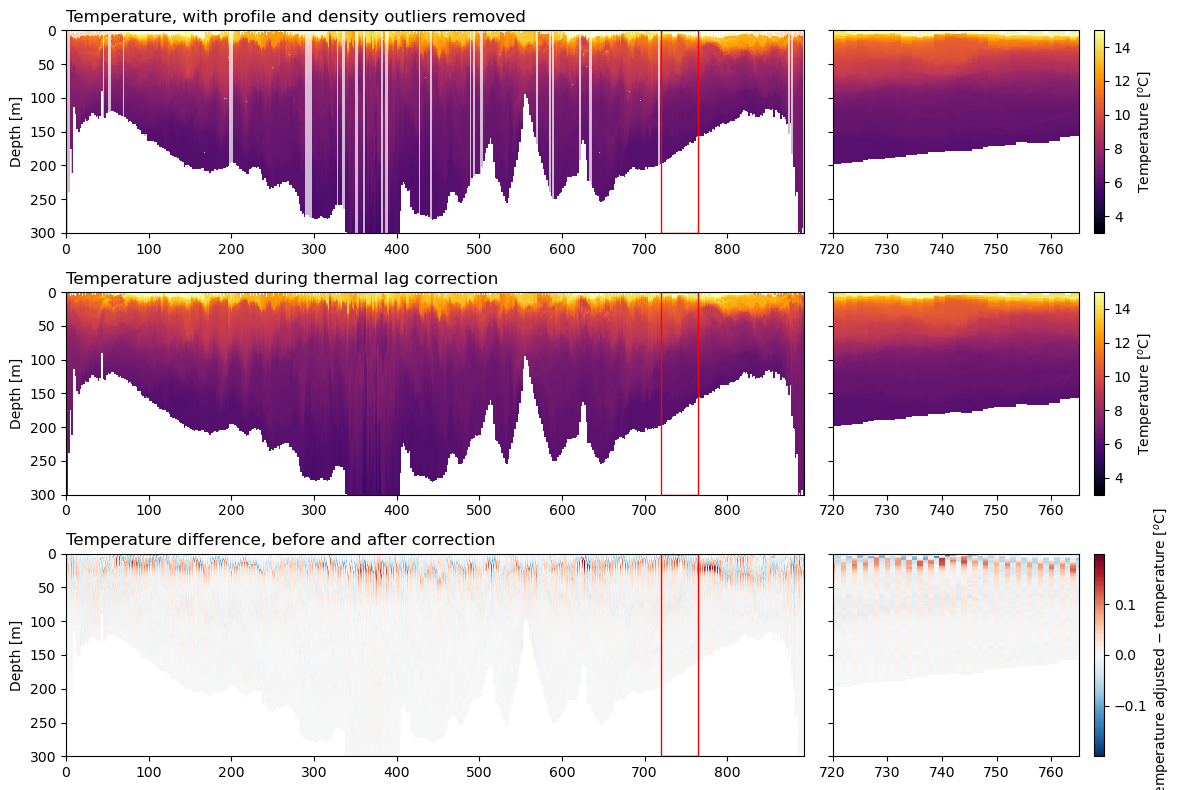

In [53]:
# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharey=True, width_ratios=[3,1.25], squeeze=True)

# Limits
xlims = [0, NUM_PROFILES]
ylims=[300,0]
t_lims = [3,15]

# Rectangle showing area used to get alpha and tau
from matplotlib.patches import Rectangle
# print(f'Drawing rectangle centered at: {profile_lims[0], ylims[0]}')
# rect = #, linestyle='dotted'

pc = axs[0,0].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], alpha = 0.3,cmap='inferno')
pc = axs[0,0].pcolormesh(dsbad.profile, dsbad.depth, dsbad['temperature'],rasterized=True, cmap = 'inferno',vmin=t_lims[0], vmax=t_lims[1])
axs[0,0].set_ylim(ylims)
axs[0,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[0,0])
axs[0,0].set_ylabel('Depth [m]')
axs[0,0].set_title('Temperature, with profile and density outliers removed',loc='left')
axs[0,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

pc = axs[1,0].pcolormesh(ds.profile, ds.depth, ds['temperature_adjusted'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='inferno')
axs[1,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[1,0])
axs[1,0].set_ylabel('Depth [m]')
axs[1,0].set_title('Temperature adjusted during thermal lag correction',loc='left')
axs[1,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

maxdiff = abs(np.nanmax(ds['temperature_adjusted']-ds['temperature']))
difflims = [maxdiff*-1, maxdiff]
# # difflims= [-0.2,0.2]
pc = axs[2,0].pcolormesh(ds.profile, ds.depth, ds['temperature_adjusted']-ds['temperature'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1])
axs[2,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[2,0])
axs[2,0].set_ylabel('Depth [m]')
axs[2,0].set_title('Temperature difference, before and after correction',loc='left')
axs[2,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

# # Subplots from correction area

xlims = profile_lims
# Subplot from correction area
pc = axs[0,1].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], alpha = 0.3)
pc = axs[0,1].pcolormesh(dsbad.profile, dsbad.depth, dsbad['temperature'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='inferno')
axs[0,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0,1], label = 'Temperature [$^o$C]')

pc = axs[1,1].pcolormesh(ds.profile, ds.depth, ds['temperature_adjusted'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='inferno')
axs[1,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[1,1], label = 'Temperature [$^o$C]')

pc = axs[2,1].pcolormesh(ds.profile, ds.depth, ds['temperature_adjusted']-ds['temperature'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1])
axs[2,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[2,1], label = 'Temperature adjusted $-$ temperature [$^o$C]')
fig.tight_layout()

print('Temperature before (top) and after adjustment (middle), with temperature difference (bottom).')
print('Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.')
print('The profile range used to determine the thermal lag correction is shown on the right:')

Density before (top) and after adjustment (middle), with density difference (bottom).
Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.
The profile range used to determine the thermal lag correction is shown on the right:


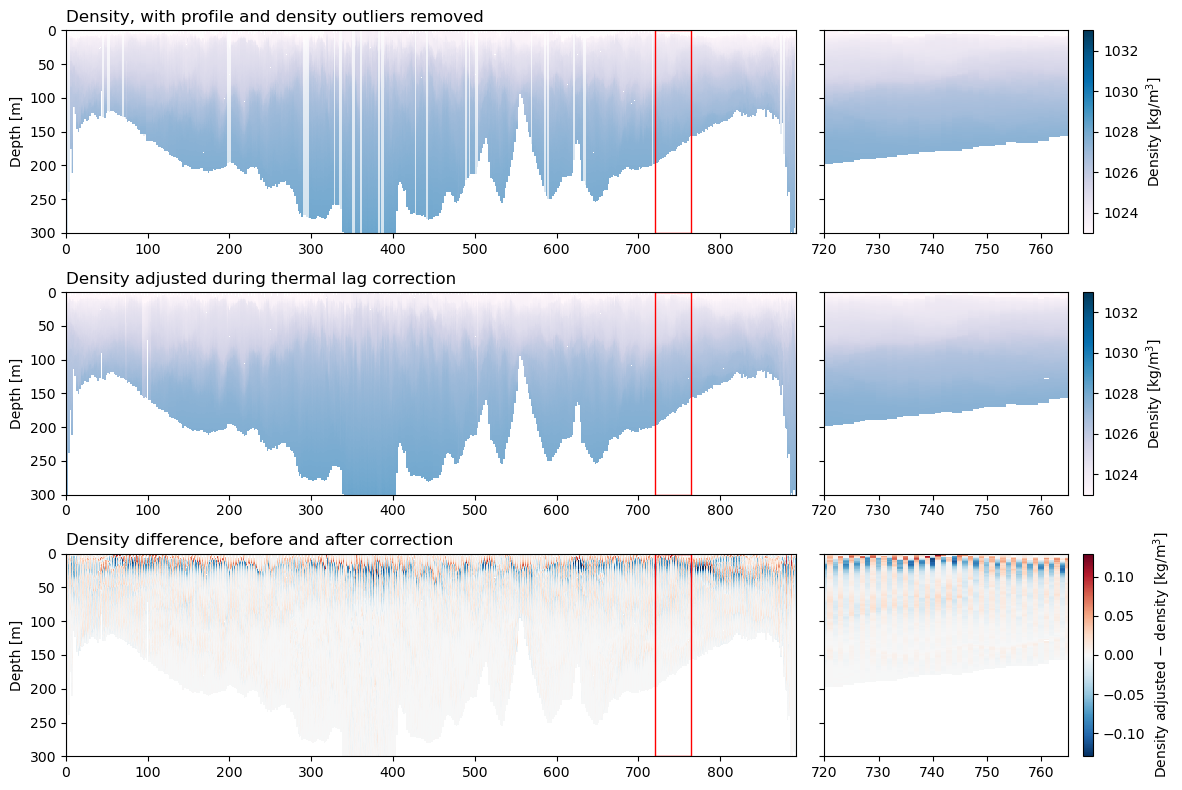

In [54]:
# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharey=True, width_ratios=[3,1.25], squeeze=True)

# Limits
xlims = [0, NUM_PROFILES]
ylims=[300,0]
t_lims = [1023,1033]

# Rectangle showing area used to get alpha and tau
from matplotlib.patches import Rectangle
# print(f'Drawing rectangle centered at: {profile_lims[0], ylims[0]}')
# rect = #, linestyle='dotted'

pc = axs[0,0].pcolormesh(ds.profile, ds.depth, ds['density'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], alpha = 0.3,cmap='PuBu')
pc = axs[0,0].pcolormesh(dsbad.profile, dsbad.depth, dsbad['density'],rasterized=True, cmap = 'PuBu',vmin=t_lims[0], vmax=t_lims[1])
axs[0,0].set_ylim(ylims)
axs[0,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[0,0])
axs[0,0].set_ylabel('Depth [m]')
axs[0,0].set_title('Density, with profile and density outliers removed',loc='left')
axs[0,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

pc = axs[1,0].pcolormesh(ds.profile, ds.depth, ds['density_adjusted'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='PuBu')
axs[1,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[1,0])
axs[1,0].set_ylabel('Depth [m]')
axs[1,0].set_title('Density adjusted during thermal lag correction',loc='left')
axs[1,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

maxdiff = abs(np.nanmax(ds['density_adjusted']-ds['density']))
difflims = [maxdiff*-1, maxdiff]
# # difflims= [-0.2,0.2]
pc = axs[2,0].pcolormesh(ds.profile, ds.depth, ds['density_adjusted']-ds['density'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1])
axs[2,0].set_xlim(xlims)
# fig.colorbar(pc, ax=axs[2,0])
axs[2,0].set_ylabel('Depth [m]')
axs[2,0].set_title('Density difference, before and after correction',loc='left')
axs[2,0].add_patch(Rectangle(xy=(profile_lims[0], ylims[1]), width = profile_lims[1]-profile_lims[0], height = ylims[0]-ylims[1], 
                         edgecolor = 'r', facecolor='none', linewidth=1))

# # # Subplots from correction area

xlims = profile_lims
# Subplot from correction area
pc = axs[0,1].pcolormesh(ds.profile, ds.depth, ds['density'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], alpha = 0.3, cmap='PuBu')
pc = axs[0,1].pcolormesh(dsbad.profile, dsbad.depth, dsbad['density'],rasterized=True, cmap='PuBu',vmin=t_lims[0], vmax=t_lims[1])
axs[0,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0,1], label = 'Density [kg/m$^3$]')

pc = axs[1,1].pcolormesh(ds.profile, ds.depth, ds['density_adjusted'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='PuBu')
axs[1,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[1,1], label = 'Density [kg/m$^3$]')

pc = axs[2,1].pcolormesh(ds.profile, ds.depth, ds['density_adjusted']-ds['density'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1], rasterized=True)
axs[2,1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[2,1], label = 'Density adjusted $-$ density [kg/m$^3$]')
fig.tight_layout()
print('Density before (top) and after adjustment (middle), with density difference (bottom).')
print('Profiles and data points that were ignored for thermal lag correction are shaded in the top plot.')
print('The profile range used to determine the thermal lag correction is shown on the right:')

### 2.4.3 Quantifying improvement

To quantify the improvement of the thermal lag correction further, the area of profile pairs was re-calculated and compared to the area between profiles prior to correction. This is calculated from the same quality-controlled data, with suspicious profiles and profile-pairs removed, as during the thermal lag correction, but using **evenly spaced profile pairs** across the deployment. 

When examining the corrected data (shown in <font color='orange'>**orange**</font>) relative to the uncorrected data (shown in **black**), we can see that up-down asymmetry was reduced, as well as a greater reduction compared to using Janzen and Creed constants (shown in <font color='red'>**red**</font>). Overall, we can see a large reduction in the area between profiles when using the calculated alpha and tau values. When looking at evenly spaced profiles across the deployment, some pairs have much larger area (e.g. in the middle of the deployment), whereas others remained quite low. When comparing upcasts and downcasts before and after correction in a T-S plot, we also see that they are much better aligned.

In [55]:
fname=f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_thermal_lag.nc'

In [56]:
# Set up our constants
fn = 0.5*fs #frequency for Sea-Bird GPCTD
density_cutoff = 1023 #exclude everything less dense than this from the minimization
num_profs = 100 #number of profiles to include in the subset of data
clean_profs_start = 0#110 #50 #number of profiles to exclude from the start
clean_profs_end = 0#50 #number of profiles to exclude from the end
dn_stdev = 1 #how many standard deviations from the mean the area between downcasts can be

# Load time series
ts = xr.load_dataset(fname)#ds1.copy(deep=True)
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate
tot_profs = int(np.nanmax(ts.profile_index.values))
print('Total number of profiles:', tot_profs)

# Overwrite conductivity in our working xarray with the clean, aligned conductivity field
ts['conductivity'] = ts.conductivityClean

# prof_lims=[profile_lims[0], profile_lims[0]+20]
# ts = ts.where((ts.profile_index >= prof_lims[0]) & (ts.profile_index <= prof_lims[1]), drop=True)
# print(prof_lims)

Total number of profiles: 893


In [57]:
# Determine pairs of profiles for the selected subset of data
ts_sub, profile_bins, profile_bins_all, direction = pgs.profile_pairs(
    ts, clean_profs_start, clean_profs_end, num_profs, bad_profiles
)

# Identify boolean index for application of density cutoff 
density_bool = ts_sub.density>=density_cutoff

#Determine the RMSD for the subset of profiles with no corrections applied
area_bad = np.full_like(profile_bins_all, False, dtype=bool)

In [58]:
# Data for the plot below!

# Calculate the area between pairs of profiles for the corrected data
# Alpha and tau values from above

# print(f'Calculating area using alpha {alpha} and tau {tau}')
area_1, p_ind_1 = pgs.TS_diff((alpha*1000, tau),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

# # Janzen and creed values
# print(f'Calculating area using alpha {alpha2} and tau {tau2}')
area_2, p_ind_2 = pgs.TS_diff((alpha2*1000, tau2),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

# Original, uncorrected values
# print(f'Calculating area with no corrections')
area_0, p_ind_0 = pgs.TS_diff((0, 0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

Total area mean before correction = 0.40727660462186877
Total area mean after correction = 0.24961628111707976
Total area anomaly mean = -0.15766032350478898
Total area anomaly median = -0.17929217414332418
*****
Top: The area between 100 profile pairs when uncorrected (black), using Janzen and Creed alpha 
and tau values (red) and when corrected with alpha = 47.5 and tau = 25.5, shown by profile index and as a histogram.
Bottom: the area change between profile pairs when corrected with calculated alpha and tau. Shown by profile index (left) and histogram (right):


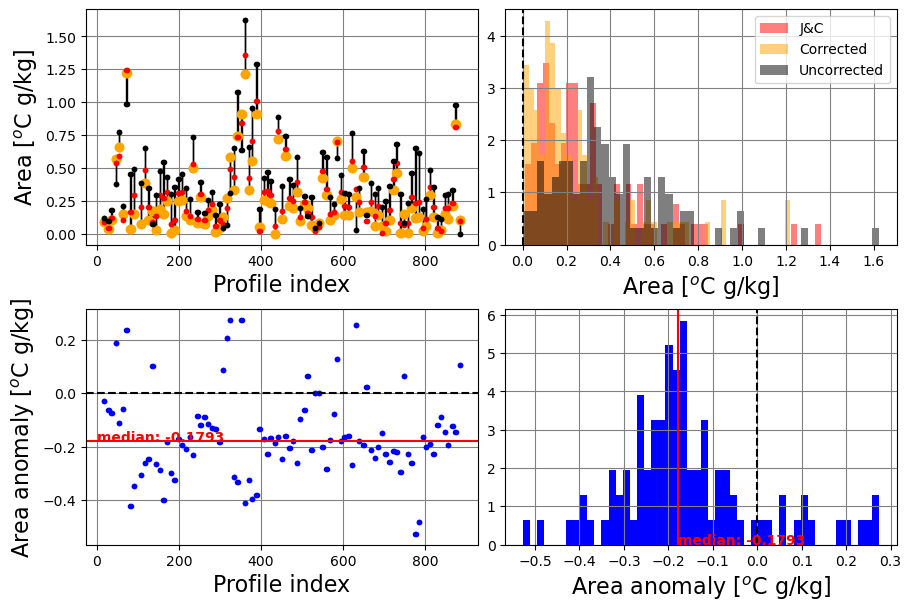

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(9, 6), 
                           constrained_layout=True)
area_uncorrected = area_0
area_corrected=area_1
area_jandc = area_2

profile_index = p_ind_1

n_bins = 50

ax[0][0].plot([profile_index,profile_index], [(area_corrected),(area_uncorrected)],
               'k', linestyle='-', linewidth = 1);
    
ax[0][0].plot(p_ind_1, area_corrected,
           color='orange', marker='o', linestyle='None');
ax[0][0].plot(p_ind_1, area_jandc,
           color='red', marker='.', linestyle='None');
ax[0][0].plot(p_ind_0, area_uncorrected,
           'k.', linestyle='None');
ax[0][0].set_ylabel('Area [$^o$C g/kg]', fontsize=16)
ax[0][0].set_xlabel('Profile index', fontsize=16)
ax[0][0].grid(color='0.5')

# Histogram
ax[0][1].hist(area_jandc, n_bins, density=True, histtype='bar', 
              color='red', label='J&C', alpha = 0.5)
ax[0][1].hist(area_corrected, n_bins, density=True, histtype='bar', 
              color='orange', label='Corrected', alpha = 0.5)
ax[0][1].hist(area_uncorrected, n_bins, density=True, histtype='bar', 
              color='black', label='Uncorrected', alpha = 0.5)
ax[0][1].legend(prop={'size': 10})
ax[0][1].axvline(x = 0, color = 'k', linestyle = '--')
ax[0][1].set_xlabel('Area [$^o$C g/kg]', fontsize=16)
ax[0][1].grid(color='0.5')

ax[1][0].plot(profile_index, 
           (area_corrected)-(area_uncorrected),
           color='blue', marker='.', linestyle='None');
ax[1][0].set_ylabel('Area anomaly [$^o$C g/kg]', fontsize=16)
ax[1][0].set_xlabel('Profile index', fontsize=16)
ax[1][0].grid(color='0.5')
ax[1][0].axhline(y = 0, color = 'k', linestyle = '--')
ax[1][0].axhline(y = np.nanmedian((area_corrected)-(area_uncorrected)), color = 'r', linestyle = '-')
ax[1][0].text(0, np.nanmedian((area_corrected)-(area_uncorrected)), 
              f'median: {str(round(np.nanmedian((area_corrected)-(area_uncorrected)), 4))}', color = 'r', weight = 'bold')

ax[1][1].hist((area_corrected)-(area_uncorrected), n_bins, density=True, histtype='bar', 
              color='blue')
ax[1][1].set_xlabel('Area anomaly [$^o$C g/kg]', fontsize=16)
ax[1][1].grid(color='0.5')
ax[1][1].axvline(x = 0, color = 'k', linestyle = '--')
ax[1][1].axvline(x = np.nanmedian((area_corrected)-(area_uncorrected)), color = 'r', linestyle = '-')
ax[1][1].text(np.nanmedian((area_corrected)-(area_uncorrected)), 0, 
              f'median: {str(round(np.nanmedian((area_corrected)-(area_uncorrected)), 4))}', color = 'r', weight = 'bold')

# caption = ('Area between pairs of salinity profiles, calculated in temperature-salinity space, ' 
#          'plotted vs. profile index number (left) and as a histogram (right), for the uncorrected ' 
#          'salinity field (orange) and the corrected salinity field (black), and as an anomaly between ' 
#          'the uncorrected and corrected fields (bottom row, blue).')
# print(caption)

# # plot_correctedarea(p_ind_2, area_0, area_2, n_bins, caption)
print('Total area mean before correction =', np.nanmean(area_0))
print('Total area mean after correction =', np.nanmean(area_1))
print('Total area anomaly mean =', np.nanmean(area_1-area_0))
print('Total area anomaly median =', np.nanmedian(area_1-area_0))
print('*****')
print(f'Top: The area between {num_profs} profile pairs when uncorrected (black), using Janzen and Creed alpha ')
print(f'and tau values (red) and when corrected with alpha = {alpha*1000} and tau = {tau}, shown by profile index and as a histogram.')
print(f'Bottom: the area change between profile pairs when corrected with calculated alpha and tau. Shown by profile index (left) and histogram (right):')

Temperature-salinity diagrams for all profiles, showing the difference between downcasts (blue) and uncorrected data (black) on the left, and upcasts (red) and uncorrected data (black) on the right panel:
*****
alpha = 0.0475, tau = 25.5


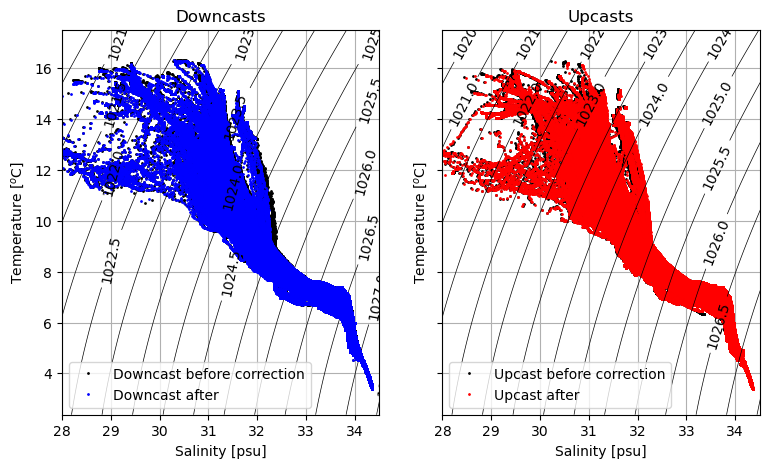

In [60]:
#Compare the uncorrected and corrected data in T-S space

print('Temperature-salinity diagrams for all profiles, '
      'showing the difference between downcasts (blue) and uncorrected data (black) on the left, '
      'and upcasts (red) and uncorrected data (black) on the right panel:')
print('*****')

x_lim=[28, 34.5]

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ds.salinity)-0.5, 
                      np.max(ds.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ds.temperature)-1, 
                      np.max(ds.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

# Apply the correction to a small subset of the full dataset for plotting
ts_f = ts.copy()
for bad in bad_profiles:
    ts_f = ts_f.where(~(ts_f.profile_index==bad))
ts_f = ts_f.where(np.isfinite(ts_f.temperature + 
                                  ts_f.conductivityClean))
ts_f = ts_f.where(ts_f.conductivityClean>=0)
# ts_f = ts_f.isel(time=range(46400*4, 46400*6))

ts_ff, xf = pgs.TS_apply((alpha*1000, tau), fn, bad_profiles, ts)

#Plotting
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,5))

ind = np.where(ts_f.profile_direction.values== 1)[0]
ax[0].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'k.', markersize=2, label = 'Downcast before correction')

ind = np.where(ts_f.profile_direction.values == -1)[0]
ax[1].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'k.', markersize=2, label = 'Upcast before correction')

CS = ax[0].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[0].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[0].set_ylabel('Temperature [$^o$C]')
ax[0].set_xlabel('Salinity [psu]')
ax[0].set_title('Downcasts')
ax[0].set_xlim(x_lim)
ax[0].grid()

ind = np.where(ts_f.profile_direction.values== 1)[0]
ax[0].plot(ts_ff.salinity_corrected[ind], ts_ff.temperature_adjusted[ind], 'b.', markersize=2, label = 'Downcast after')
ax[0].legend(prop={'size': 10})

ind = np.where(ts_ff.profile_direction.values==-1)[0]
ax[1].plot(ts_ff.salinity_corrected[ind], ts_ff.temperature_adjusted[ind], 'r.', markersize=2, label = 'Upcast after')
ax[1].legend(prop={'size': 10})
CS = ax[1].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[1].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[1].set_ylabel('Temperature [$^o$C]')
ax[1].set_xlabel('Salinity [psu]')
ax[1].set_title('Upcasts')
ax[1].grid();

Temperature-salinity diagrams for all profiles, showing the difference between upcasts (red) and downcasts (blue), for the data without the thermal lag correction applied (left panel) and the data with the thermal lag correction applied (right panel):


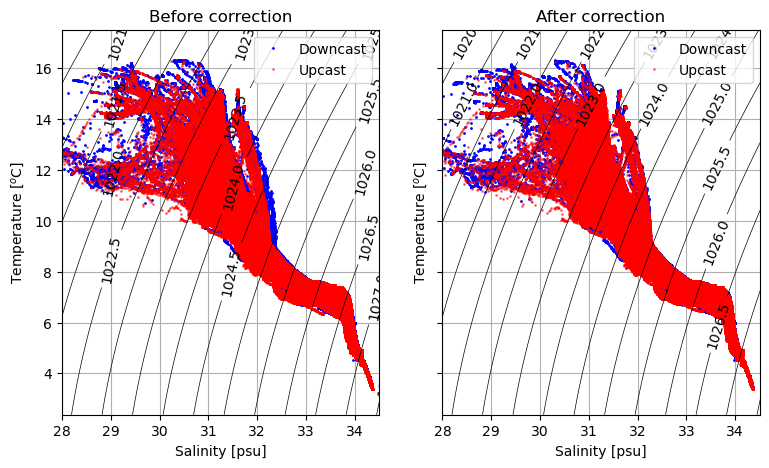

In [61]:
#Compare the uncorrected and corrected data in T-S space

print('Temperature-salinity diagrams for all profiles, '
      'showing the difference between upcasts (red) and downcasts (blue), '
      'for the data without the thermal lag correction applied (left panel) and '
      'the data with the thermal lag correction applied (right panel):')

x_lim=[28, 34.5]

#Plotting
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,5))

ind = np.where(ts_f.profile_direction.values== 1)[0]
ax[0].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'b.', markersize=2, rasterized=True, label = 'Downcast')

ind = np.where(ts_f.profile_direction.values == -1)[0]
ax[0].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'r.', markersize=2, alpha = 0.5, rasterized=True, label = 'Upcast')

CS = ax[0].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[0].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[0].set_ylabel('Temperature [$^o$C]')
ax[0].set_xlabel('Salinity [psu]')
ax[0].set_title('Before correction')
ax[0].set_xlim(x_lim)
ax[0].grid()

ind = np.where(ts_f.profile_direction.values== 1)[0]
ax[1].plot(ts_ff.salinity_corrected[ind], ts_ff.temperature_adjusted[ind], 'b.', markersize=2, rasterized=True, label = 'Downcast')
ind = np.where(ts_ff.profile_direction.values==-1)[0]
ax[1].plot(ts_ff.salinity_corrected[ind], ts_ff.temperature_adjusted[ind], 'r.', markersize=2, alpha = 0.5, rasterized=True, label = 'Upcast')

CS = ax[1].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[1].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[1].set_ylabel('Temperature [$^o$C]')
ax[1].set_xlabel('Salinity [psu]')
ax[1].set_title('After correction')
ax[1].grid()

ax[0].legend(prop={'size': 10});
ax[1].legend(prop={'size': 10});

# 3.0 Summary of corrections applied to delayed mode data for this mission
**Identification of anomalous conductivity values:**
   * Anomalous conductivity values at the surface caused by air bubbles in the cell were set to NaN.
     
**Sensor alignment correction:**
   * No sensor alignment correction was applied.
     
**Identification of questionable salinity profiles:**
   * Numerous salinity profiles were flagged as 'bad' and their values set to NaN for the thermal lag correction. The range of profiles examined was not limited, and these profiles were not removed from the final corrected salinity dataset.
     
**Thermal lag correction:**
   * The directly determined values for the thermal lag correction produced an improvement that was larger than the recommended values from Janzen and Creed (2011).
   * The correction overall significantly reduced the root-mean squared difference for the area between between pairs of profiles.
   * The final thermal lag correction was applied using the calculated values of: 

In [62]:
print(f'alpha = {alpha} and tau = {tau}')

alpha = 0.0475 and tau = 25.5


In [63]:
# Set up and our final datasets
ts_final = ts
# Drop the bad profiles - NOT DOING THIS !
# ind = np.where(ts_final.profile_index.isin(bad_profiles))[0]
# ts_final.salinity_corrected[ind] = np.nan

In [64]:

ts0 = pgs.get_timeseries(filepath, deploy_name)

# Uncorrected conductivity
ts0['conductivity0'] = ts0.conductivity.copy()
ts0.conductivity0.values = ts0.conductivity.values
ts0['conductivity0'].attrs['comment'] = 'uncorrected conductivity'
ts0['conductivity0'].attrs['processing_report'] = processing_report
ts0['conductivity0'].attrs['processing_date'] = processing_date
ts0['conductivity0'].attrs['processing_date'] = processing_protocol

# Corrected (aka cleaned) conductivity
ts0['conductivity'] = ts_final.conductivity.copy()
ts0.conductivity.values = ts_final.conductivityClean.values
ts0['conductivity'].attrs['comment'] = 'corrected conductivity'
ts0['conductivity'].attrs['processing_report'] = processing_report
ts0['conductivity'].attrs['processing_date'] = processing_date
ts0['conductivity'].attrs['processing_date'] = processing_protocol

# Uncorrected temperature
ts0['temperature0'] = ts0.temperature.copy()
ts0.temperature0.values = ts0.temperature.values
ts0['temperature0'].attrs['comment'] = 'uncorrected temperature [degC]'

# Adjusted temperature
ts0['temperature'] = ts_final.temperature_adjusted.copy()
ts0.temperature.values = ts_final.temperature_adjusted.values
ts0['temperature'].attrs['comment'] = 'corrected temperature [degC]'
ts0['temperature'].attrs['processing_report'] = processing_report
ts0['temperature'].attrs['processing_date'] = processing_date
ts0['temperature'].attrs['processing_date'] = processing_protocol

# Uncorrected salinity
ts0['salinity0'] = ts0.salinity.copy()
ts0.salinity0.values = ts0.salinity.values
ts0['salinity0'].attrs['comment'] = 'uncorrected salinity [psu]'

# Corrected salinity
ts0['salinity'] = ts_final.salinity_corrected.copy()
ts0.salinity.values = ts_final.salinity_corrected.values
ts0['salinity'].attrs['comment'] = 'corrected salinity [psu]'
ts0['salinity'].attrs['method'] = ' '
ts0['salinity'].attrs['processing_report'] = processing_report
ts0['salinity'].attrs['processing_date'] = processing_date
ts0['salinity'].attrs['processing_protocol'] = processing_protocol

# Unadjusted density
ts0['density0'] = ts0.density.copy()
ts0.density0.values = ts0.density.values
ts0['density0'].attrs['comment'] = 'unadjusted density'

# Adjusted density
ts0['density'] = ts_final.density_adjusted.copy()
ts0.density.values = ts_final.density_adjusted.values
ts0['density'].attrs['comment'] = 'density from corrected salinity [psu] and temperature [degC]'
ts0['density'].attrs['method'] = ' '

The corrected temperature and salinity fields shown in a T-S diagram with density contours:


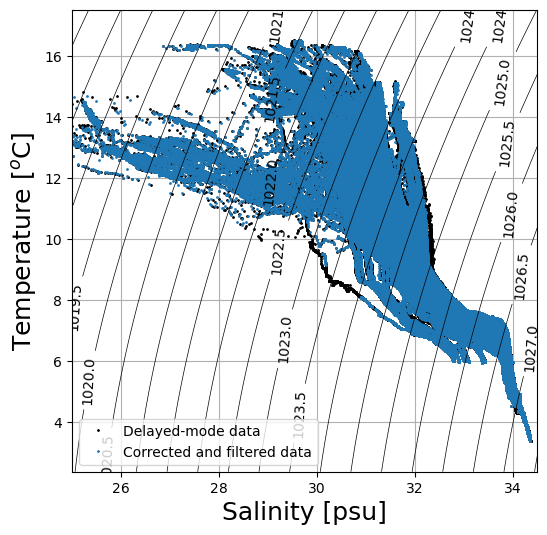

In [65]:
# Visualize the final data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
X_LIM = [25,34.5]
# T-S diagram for fully corrected data
ax0 = ax
ax0.plot(ts0.salinity0,ts0.temperature0,'k.',markersize=2, label = "Delayed-mode data")
ax0.plot(ts0.salinity,ts0.temperature,'.',markersize=2, label = "Corrected and filtered data")

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.nanmin(ts0.salinity)-0.5, 
                      np.nanmax(ts0.salinity)+0.5, 1000)
T_range = np.linspace(np.nanmin(ts0.temperature)-1, 
                      np.nanmax(ts0.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = ax0.contour(S_range, T_range, density_grid,
                np.arange(1014,
                          np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax0.clabel(CS, CS.levels, inline=True, fontsize=10)
ax0.set_xlabel('Salinity [psu]', fontsize=18)
ax0.set_ylabel('Temperature [$^o$C]', fontsize=18)
ax0.set_xlim(X_LIM)
ax0.grid()
ax0.legend()

print('The corrected temperature and salinity fields '
      'shown in a T-S diagram with density contours:')

In [66]:
# Save our final datasets
ts0.to_netcdf(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_adjusted.nc')
# print(f'Corrected data saved to file: {filepath}/{glider_name}/{deploy_name}/{deploy_name}_adjusted.nc')

In [67]:
# ds.close()
import pyglider.ncprocess as ncprocess
ncprocess.make_gridfiles(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_adjusted.nc', 
                         f'{filepath}/{glider_name}/{deploy_name}', deployfile, fnamesuffix='_adjusted')

'e:/Glider/data//dfo-bb046/dfo-bb046-20220707/dfo-bb046-20220707_grid_adjusted.nc'

The corrected salinity and temperature, shown with filtered conductivity and adjusted density:


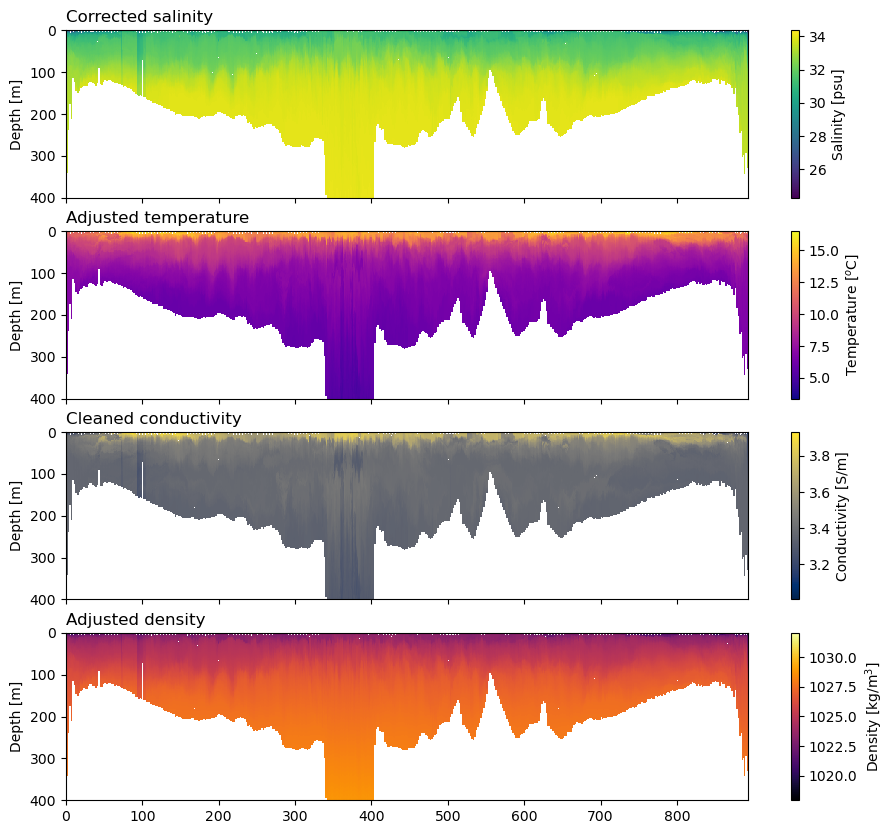

In [68]:
# Open the grid file
ds=xr.open_dataset(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_grid_adjusted.nc')
# list(ds.keys())

# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(4, 1, figsize=(11, 10), sharey=True, sharex=True)

xlims = [0, NUM_PROFILES]
ylims=[400,0]

pc = axs[0 ].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True)
axs[0].set_ylim(ylims)
axs[0].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = 'Salinity [psu]')
axs[0].set_title('Corrected salinity',loc='left')

pc = axs[1].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,cmap='plasma')
fig.colorbar(pc, ax=axs[1], label = 'Temperature [$^o$C]')
axs[1].set_title('Adjusted temperature',loc='left')

pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivity'],rasterized=True,cmap='cividis')
fig.colorbar(pc, ax=axs[2], label = 'Conductivity [S/m]')
axs[2].set_title('Cleaned conductivity',loc='left')

# pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['oxygen_concentration'],rasterized=True,cmap='inferno')
# fig.colorbar(pc, ax=axs[3])
# axs[3].set_title('Oxygen Concentration',loc='left')

pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['density'],rasterized=True,cmap='inferno')
fig.colorbar(pc, ax=axs[3], label = 'Density [kg/m$^3$]')
axs[3].set_title('Adjusted density',loc='left')

axs[0].set_ylabel('Depth [m]')
axs[1].set_ylabel('Depth [m]')
axs[2].set_ylabel('Depth [m]')
axs[3].set_ylabel('Depth [m]')

print('The corrected salinity and temperature, shown with filtered conductivity and adjusted density:')

In [69]:
display(Markdown('./docs/CTD_References.md'))

# References

1.	Ferrari, R., and Rudnick, D. L. Thermohaline variability in the upper ocean, J. Geophys. Res., 105(C7), 16857-16883, 2000.

2.	Garau, B., Ruiz, S., Zhang, W. G., Pascual, A., Heslop, E., Kerfoot, J., & Tintoré, J. Thermal Lag Correction on Slocum CTD Glider Data, J. Atmos. Oceanic Technol., 28(9), 1065-1071, 2011. 

3.	Janzen, C. D.,  and Creed, E. L. Physical oceanographic data from Seaglider trials in stratified coastal waters using a new pumped payload CTD, OCEANS'11 MTS/IEEE KONA, Waikoloa, HI, USA, 1-7, 2011.

4.	Morison, J., Andersen, R., Larson, N., D’Asaro, E., & Boyd, T. The correction for thermal-lag effects in Sea-Bird CTD data, J. Atmos. Oceanic Technol., 11, 1151-1164, 1994.

5.	Sea-Bird Seasoft V2:SBE Data Processing - CTD Data Processing & Plotting Software for Windows, Sea-Bird Scientific, software manual revision 7.26.8, 2017.

6.	Sea-Bird User Manual - GPCTD Glider Payload CTD (optional DO) - Conductivity, Temperature, and Pressure (optional DO) Sensor with RS-232 Interface, Sea-Bird Scientific, manual version 008, 2021. 
